In [1]:
# %matplotlib widget

import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf
import PandemiXModelFunctions as pmf

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.facecolor'] = (1,1,1,1)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)

import datetime
             
from scipy.integrate import cumtrapz
# int_I = cumtrapz(np.exp(u_H*ts)*Is,ts, initial=0)
# Hs = np.exp(-u_H*ts) * (r_chr*pars_full['gamma']*int_I + k) 

In [2]:
saveFigures = True
saveFigures = False

# np.log(0.2)


In [3]:
# Reload PandemiXModelFunctions, in case changes have been made
import importlib 
importlib.reload(pmf)

<module 'PandemiXModelFunctions' from 'c:\\Users\\rakrpe\\GithubRepos\\PandemiX\\modelling\\PandemiXModelFunctions.py'>

# Model description

SEIR model, testing leads to isolation. Parameters should be number of tests and efficacy of test (and of isolation)

S -> E1 -> E2 -> P -> I -> Q/A -> R

(Q: Quarantine, both due to testing and symptomatic)
(A: Asymptomatic)

with E2 -> Q, P -> Q and A -> Q rates controlled by testing


(P is pre-symptomatic, E1 is exposed but before the point where testing would catch it, E2 is pre-infectious, but can be found by testing)


Flows:
* S -> E1
* E1 -> E2
* E2 -> P
* P -> I
* I -> Q
* I -> A
* Q -> R
* A -> R 
* Additional flow that are all testing dependent:
* E2 -> Q
* P -> Q
* A -> Q

Infection pressure: P + A (+ partially I and Q?)

In [4]:
# Model with explicit symptomatic category and keeping track of whether recovered were found or not
modelMeta = ({
     'beta * S * (P+A)' : ['S','E1'],
     'gamma * E1' : ['E1','E2'],
     'gamma * E2' : ['E2','P'],
     'gamma * rho * P' : ['P','I'],
     'gamma * (1-rho) * P' : ['P','A'],
     'nu * A' : ['A',None],
     'nu * Q' : ['Q','Rp'],
     # 'nu * I' : ['I',None],
     'nu * I' : ['I','Rp'], # Assuming that symptomatic cases get test, but aren't included in Q 
     'tau * E2' : ['E2','Q'],
     'tau * P'  : ['P','Q'],
     'tau * A'  : ['A','Q'],
     # 'tau * I'  : ['I','Q'], # Testing of symptomatic cases
     # 'tauInf * I'  : ['I','Q'], # Testing of symptomatic cases
     
},
# ['S','E1','E2','P','A','Q','I','Rp'],['beta','gamma','nu','rho','tau','testProbInf'])
['S','E1','E2','P','A','Q','I','Rp'],['beta','gamma','nu','rho','tau'])

# # Model with explicit symptomatic category and keeping track of whether recovered were found or not
# modelMeta_symp_rec = ({
#      'beta * S * (I+A)' : ['S','E1'],
#      'gamma * E1' : ['E1','E2'],
#      'gamma * E2' : ['E2','I'],
#      'gamma * sympRate * I' : ['I','I2'],
#      'gamma * (1-sympRate) * I' : ['I','A'],
#      'nu * A' : ['A',None],
#      'nu * Q' : ['Q','Rp'],
#      'nu * I2' : ['I2',None],
#      'testProb * E2' : ['E2','Q'],
#      'testProb * I'  : ['I','Q'],
#      'testProb * A'  : ['A','Q'],
#      'testProb * I2'  : ['I2','Q'], # Testing of symptomatic cases
# },
# ['S','E1','E2','I','A','Q','I2','Rp'],['beta','gamma','nu','sympRate','testProb'])

In [5]:
# Initialize everything

DKpop = 5800000
iniExp = 10

E1_0 = iniExp/DKpop 
E2_0 = 0
P_0 = 0
A_0 = 0
Q_0 = 0
I_0 = 0
R_0 = 0
Rp_0 = 0
S_0 = 1 - E1_0 - E2_0 - P_0 - A_0 - Q_0 - R_0 - I_0 - Rp_0

# init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'P':P_0,'A':A_0,'Q':Q_0,'I':I_0,'Rp':Rp_0}
init = {'S' : S_0,'E1':E1_0,'E2':0 , 'P':0,'A':0,'Q':0,'I':0,'Rp':0}

gamma = 1/3
nu = 1/3
rho = 0.5
beta = 3*5/7
tau = 0.95 * 1/3
beta  = 4
tau = 0.55
# beta  = 2
# tau = 0.15
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}


tEnd = 300 
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])
sch1.simulate(tRes=1000)

Rs = 1- sch1.result.y.sum(axis=0)

# fig,ax1 = plt.subplots()
# # ax1.plot(sch1.result.t,sch1.result.E1)
# ax1.plot(sch1.result.t,sch1.result.Rp)
# ax1.plot(sch1.result.t,sch1.result.Rp+Rs)
# ax1.plot(sch1.result.t,sch1.result.S)
# ax1.plot(sch1.result.t,sch1.result.Q)
# ax1.plot(sch1.result.t,sch1.result.Q+sch1.result.A)


print(f'Fraction found positive: {sch1.result.Rp[-1]:0.2f}')
print(f'Fraction never positive: {Rs[-1]:0.2f}')
print(f'Fraction ever sick: {1-sch1.result.S[-1]:0.2f}')
print(f'Fraction susceptible: {sch1.result.S[-1]:0.2f}')



Fraction found positive: 0.78
Fraction never positive: 0.02
Fraction ever sick: 0.81
Fraction susceptible: 0.19


In [6]:
def getBetaFromTauAndSigma(tau,sigma,pars):

    gamma = pars['gamma']
    nu = pars['nu']
    rho = pars['rho']

    estiTE = (1-sigma)/(gamma+tau)
    estiTP = (1-sigma - tau*estiTE)/(gamma+tau)
    estiTA = (1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau)

    beta = -np.log(sigma)/(estiTP+estiTA)
    

    return beta 

In [7]:

newTau = 0.5*pars['tau']
newBeta =  getBetaFromTauAndSigma(newTau,sch1.result.S[-1],pars)
newPars = {'beta':newBeta,'nu':nu,'gamma':gamma,'rho':rho,'tau':newTau}


tEnd = 500 
sch2 = pmf.Scheme(modelMeta,init,newPars,0,tEnd,Changes=[])
sch2.simulate(tRes=1000)

Rs2 = 1- sch2.result.y.sum(axis=0)

# fig,ax1 = plt.subplots()
# # ax1.plot(sch2.result.t,sch2.result.E1)
# ax1.plot(sch2.result.t,sch2.result.Rp)
# ax1.plot(sch2.result.t,sch2.result.Rp+Rs2)
# ax1.plot(sch2.result.t,sch2.result.S)

print(f'Fraction found positive: {sch2.result.Rp[-1]:0.2f}')
print(f'Fraction never positive: {Rs2[-1]:0.2f}')
print(f'Fraction ever sick: {1-sch2.result.S[-1]:0.2f}')
print(f'Fraction susceptible: {sch2.result.S[-1]:0.2f}')
# print(f'Fraction found positive out of all cases: {sch2.result.Rp[-1]/(1-sch2.result.S[-1])}')

rp = sch2.result.Rp[-1]
rn = Rs2[-1]
1-rp/(rn+rp) 



Fraction found positive: 0.74
Fraction never positive: 0.07
Fraction ever sick: 0.81
Fraction susceptible: 0.19


0.0822586159592229

In [8]:
curTA = np.trapz(sch1.result.A,sch1.result.t)
curTE = np.trapz(sch1.result.E2,sch1.result.t)
curTP = np.trapz(sch1.result.P,sch1.result.t)

sigma = sch1.result.S[-1]


estiTE = (1-sigma)/(gamma+tau)

estiTP = (1-sigma - tau*estiTE)/(gamma+tau)
estiTA = (1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau)

# print(estiTP)
# print(curTP)
# print(estiTA)
# print(curTA)

rp = sch1.result.Rp[-1]
rn = Rs[-1]
print(rp)

print(nu*estiTA)
print(rn) 


print(rp/(rn+rp))

print(1-(nu*estiTA/(1-sigma)))

0.7834868600316648
0.02163178033897451
0.02163178035928559
0.9731321829180584
0.9731321829429663


In [9]:
# (nu/(nu+tau))*(1-tau/(gamma+tau))*(1-(gamma*rho+tau)/(gamma+tau))
sigma = 0.8


1-(nu*estiTA/(1-sigma))
# 1-(nu*((1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau))/(1-sigma))
# 1-(nu*((1-sigma - (gamma*rho+tau)*((1-sigma - tau*estiTE)/(gamma+tau)) - tau*estiTE)/(nu+tau))/(1-sigma))
1-(nu*((1-sigma - (gamma*rho+tau)*((1-sigma - tau*((1-sigma)/(gamma+tau)))/(gamma+tau)) - tau*((1-sigma)/(gamma+tau)))/(nu+tau))/(1-sigma))

1- (nu/(nu+tau))*(1-tau/(gamma+tau))*(1-(gamma*rho+tau)/(gamma+tau))
1 - (nu/(nu+tau)) * (1 - (tau/(gamma+tau))) * (1 - (gamma*rho + tau)/(gamma + tau))



0.9731321829429663

In [10]:
def calcFoundRatio(pars):
    gamma = pars['gamma']
    nu = pars['nu']
    rho = pars['rho']
    tau = pars['tau']

    # sigma = 0.19 
    # estiTE = (1-sigma)/(gamma+tau)
    # estiTP = (1-sigma - tau*estiTE)/(gamma+tau)
    # estiTA = (1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau)

    # toReturn = 1- (nu*estiTA)/(1-sigma)

    toReturn = 1 - (nu/(nu+tau))*(1-tau/(gamma+tau))*(1-(gamma*rho+tau)/(gamma+tau))
    return toReturn

print(calcFoundRatio(newPars))
print(calcFoundRatio(pars))

0.917741384052625
0.9731321829429663


In [11]:
tauRange = np.arange(0,1.01,0.01)
# tauRange = np.logspace(-4,0)

finRatios = np.zeros(tauRange.shape)
for i,curTau in enumerate(tauRange):
    # curPars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':curTau}
    curPars = {'beta':beta,'nu':1/3,'gamma':1/3,'rho':0.5,'tau':curTau}
    curRatio = calcFoundRatio(curPars) 
    finRatios[i] = curRatio 
 

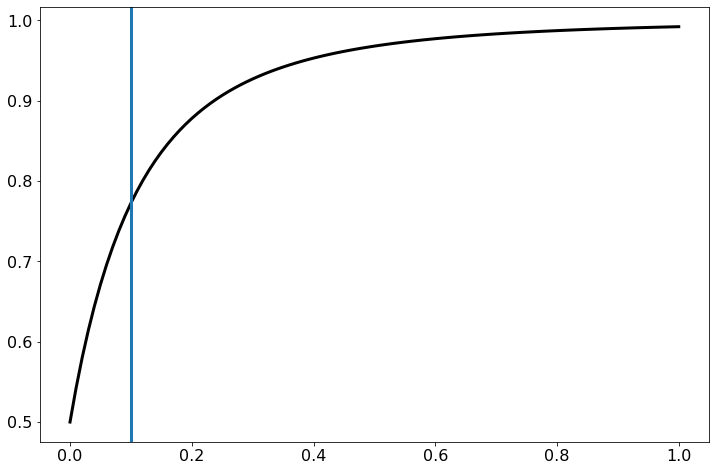

In [12]:
fig,ax = plt.subplots()
# ax.plot(np.log(tauRange),finRatios)
ax.plot(tauRange,finRatios,'k')
# ax.plot(tauRange,finRatios+finRatios*(tauRange**0.7))

# ax.set_ylim([0.5,1.2])
# ax.set_xlim([0,0.5])

ax.axvline(0.1)

In [13]:

# # cases1 = curCase / (curTest/baseTest)**beta

# baseTest = 0.05
# curTest = 0.1 
# betaTest=0.7

# (curTest/baseTest)**betaTest

# baseTest = 100000/5800000
# baseTest


(0.0, 1.5)

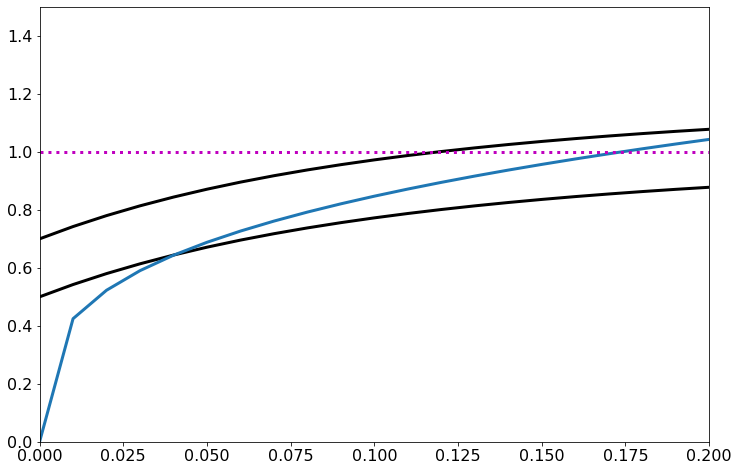

In [14]:
fig,ax = plt.subplots()
# ax.plot(tauRange,1/finRatios,'k')
ax.plot(tauRange,finRatios,'k')
ax.plot(tauRange,finRatios+0.2,'k')

baseTest = 100000/5800000
# baseTest = 0.05
betaTest = 0.3
ax.plot(tauRange,0.5*(tauRange/baseTest)**betaTest)
# ax.plot(tauRange,1/(tauRange/baseTest)**betaTest)
# ax.plot(tauRange,1/(finRatios/(tauRange/baseTest)**betaTest))

ax.axhline(1,linestyle=':',color='m')

ax.set_xlim([0,0.2])
ax.set_ylim([0,1.5])

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_49436\2909061773.py:8: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(tauRange,2/(tauRange/baseTest)**betaTest)


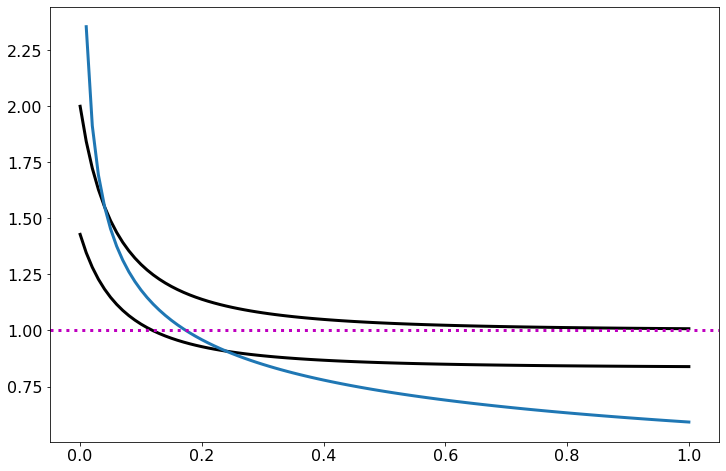

In [15]:
fig,ax = plt.subplots()
ax.plot(tauRange,1/finRatios,'k')
ax.plot(tauRange,1/(finRatios+0.2),'k')

baseTest = 100000/5800000
# baseTest = 0.05
betaTest = 0.3
ax.plot(tauRange,2/(tauRange/baseTest)**betaTest)
# ax.plot(tauRange,1/(tauRange/baseTest)**betaTest)
# ax.plot(tauRange,1/(finRatios/(tauRange/baseTest)**betaTest))

ax.axhline(1,linestyle=':',color='m')

# ax.set_xlim([0,0.2])
# ax.set_ylim([0,1.5])

# Illustrate changes to other parameters
Sort of sensitivity analysis -ish

In [16]:
rhoRange = [0.25,0.5,0.75]
gammaRange = [0.1,0.3,0.5]
nuRange = [0.1,0.3,0.5]
rhoRange = [0.1,0.25,0.5,0.75,0.9]
gammaRange = [0.05,0.1,0.2,0.3,0.4,0.5,0.6]
nuRange = [0.05,0.1,0.2,0.3,0.4,0.5,0.6]

tauRange = np.arange(0,1.01,0.01)

allFinsRho = []
for j,curRho in enumerate(rhoRange):
    finRatios = np.zeros(tauRange.shape)
    for i,curTau in enumerate(tauRange):
        curPars = {'beta':beta,'nu':0.3,'gamma':0.3,'rho':curRho,'tau':curTau}
        curRatio = calcFoundRatio(curPars) 
        finRatios[i] = curRatio 
    allFinsRho.append(finRatios)
    
allFinsGamma = []
for j,curGamma in enumerate(gammaRange):
    finRatios = np.zeros(tauRange.shape)
    for i,curTau in enumerate(tauRange):
        curPars = {'beta':beta,'nu':0.3,'gamma':curGamma,'rho':0.5,'tau':curTau}
        curRatio = calcFoundRatio(curPars) 
        finRatios[i] = curRatio 
    allFinsGamma.append(finRatios)
    
allFinsNu = []
for j,curNu in enumerate(nuRange):
    finRatios = np.zeros(tauRange.shape)
    for i,curTau in enumerate(tauRange):
        curPars = {'beta':beta,'nu':curNu,'gamma':0.3,'rho':0.5,'tau':curTau}
        curRatio = calcFoundRatio(curPars) 
        finRatios[i] = curRatio 
    allFinsNu.append(finRatios)

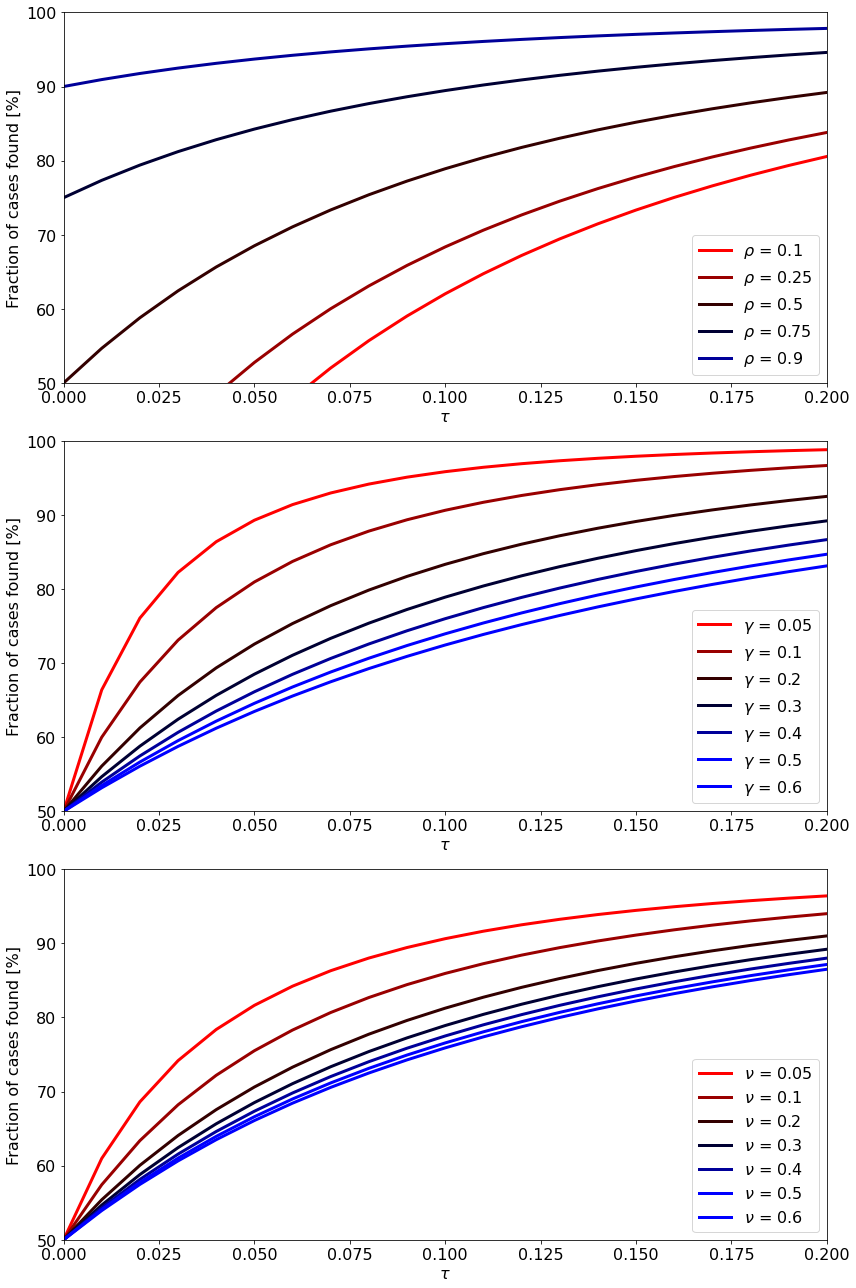

In [17]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,18))

cmap = pf.getColormapFromList(['r','k','b'],len(rhoRange)+1)

for j,curRho in enumerate(rhoRange):
    ax1.plot(tauRange,100*allFinsRho[j],label=r'$\rho$ = '+str(curRho),color=cmap(j))
for j,curGamma in enumerate(gammaRange):
    ax2.plot(tauRange,100*allFinsGamma[j],label=r'$\gamma$ = '+str(curGamma),color=cmap(j))
for j,curNu in enumerate(nuRange):
    ax3.plot(tauRange,100*allFinsNu[j],label=r'$\nu$ = '+str(curNu),color=cmap(j))


ax1.legend()
ax1.set_ylim([50,100])
ax1.set_xlim([0,0.2])
ax2.legend()
ax2.set_ylim([50,100])
ax2.set_xlim([0,0.2])
ax3.legend()
ax3.set_ylim([50,100])
ax3.set_xlim([0,0.2])


allYlabel = 'Fraction of cases found [%]'
ax1.set_ylabel(allYlabel)
ax2.set_ylabel(allYlabel)
ax3.set_ylabel(allYlabel)

allXlabel = r'$\tau$'

ax1.set_xlabel(allXlabel)
ax2.set_xlabel(allXlabel)
ax3.set_xlabel(allXlabel)

fig.tight_layout()

if saveFigures:
    fig.savefig('Figures/TestingModelling_RatioFoundFraction')

In [18]:
tau = 0.05

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_49436\1620512838.py:32: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(sch1.result.t,Rp/(Rp+Rn))


(0.65, 0.72)

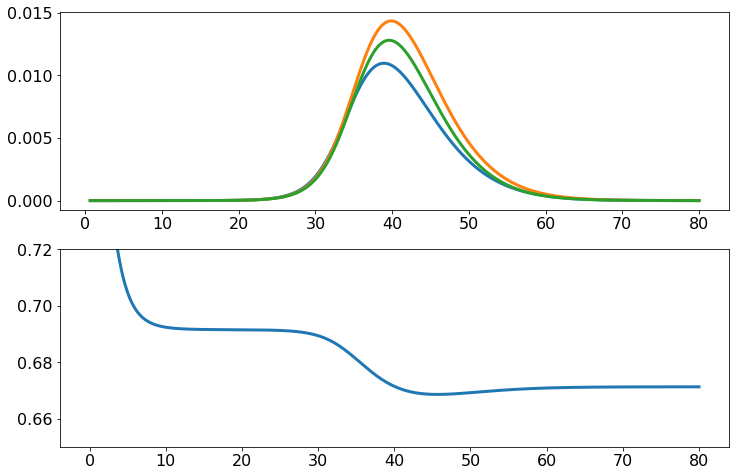

In [19]:

pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}


tEnd = 80 
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])
sch1.simulate(tRes=1000)

Rs = 1- sch1.result.y.sum(axis=0)

# fig,(ax1,ax2) = plt.subplots(2,1)
# # ax1.plot(sch1.result.t,sch1.result.E1)
# ax1.plot(sch1.result.t,sch1.result.Rp)
# ax1.plot(sch1.result.t,sch1.result.Rp+Rs)
# ax1.plot(sch1.result.t,sch1.result.S)
# ax2.plot(sch1.result.t,sch1.result.Q)
# ax2.plot(sch1.result.t,sch1.result.Q+sch1.result.A,'--')
# ax2.plot(sch1.result.t,sch1.result.I,'--')

fig,(ax1,ax2) = plt.subplots(2,1)

# ax1.plot(sch1.result.t,sch1.result.I)
ax1.plot(sch1.result.t[1+7:],nu*cumtrapz(sch1.result.Q,sch1.result.t)[7:] - nu*cumtrapz(sch1.result.Q,sch1.result.t)[:-7])
ax1.plot(sch1.result.t[1+7:],nu*cumtrapz(sch1.result.I,sch1.result.t)[7:] - nu*cumtrapz(sch1.result.I,sch1.result.t)[:-7])
ax1.plot(sch1.result.t[1+7:],nu*cumtrapz(sch1.result.A,sch1.result.t)[7:] - nu*cumtrapz(sch1.result.A,sch1.result.t)[:-7])
# ax1.plot(sch1.result.t[1+14:],nu*cumtrapz(sch1.result.Q,sch1.result.t)[14:] - nu*cumtrapz(sch1.result.Q,sch1.result.t)[:-14])
# ax1.plot(sch1.result.t,sch1.result.Q)

Rn = Rs 
Rp = sch1.result.Rp 


ax2.plot(sch1.result.t,Rp/(Rp+Rn))
ax2.set_ylim([0.65,0.72])
# ax2.set_ylim([0.5,0.82])
# ax1.plot(sch1.result.t[1:],nu*cumtrapz(sch1.result.I,sch1.result.t))
# gettingTested = tau*cumtrapz(sch1.result.S+sch1.result.E1+sch1.result.E2+sch1.result.P+sch1.result.A,sch1.result.t)
# ax1.plot(sch1.result.t[1:],)
# ax1.plot(sch1.result.t[1:],nu*cumtrapz(sch1.result.I+sch1.result.Q,sch1.result.t))
# ax1.plot(sch1.result.t[1:],nu* cumtrapz(sch1.result.A,sch1.result.t))
# ax1.plot(sch1.result.t,sch1.result.Rp,':')
# ax1.plot(sch1.result.t,Rs,':')

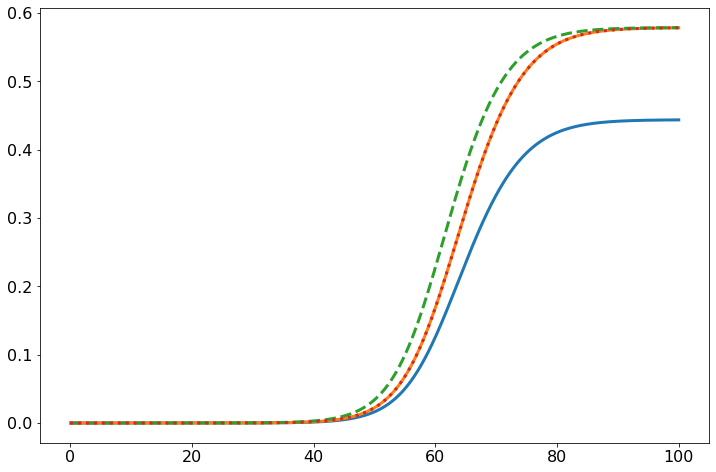

In [42]:
fig,ax = plt.subplots()
ax.plot(sch1.result.t[1:],nu*cumtrapz(sch1.result.I,sch1.result.t))
ax.plot(sch1.result.t[1:],nu*cumtrapz(sch1.result.I,sch1.result.t)+nu*cumtrapz(sch1.result.Q,sch1.result.t))
ax.plot(sch1.result.t[1:],gamma*rho*cumtrapz(sch1.result.P,sch1.result.t)+nu*cumtrapz(sch1.result.Q,sch1.result.t),'--')
ax.plot(sch1.result.t,sch1.result.Rp,':')
# ax.plot(sch1.result.t[1:],nu*cumtrapz(sch1.result.A,sch1.result.t))
# ax.plot(sch1.result.t,Rs,':')

In [21]:

gamma = 1/3
nu = 1/3
rho = 0.5
beta = 3*5/7
tau = 0.95 * 1/3
beta  = 1.5
tau = 0.05
tau = 0.02
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}


tEnd = 100 
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])
sch1.simulate(tRes=1000)

Rs =1- sch1.result.y.sum(axis=0)

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_49436\3025294325.py:9: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(sch1.result.t,sch1.result.Rp/(sch1.result.Rp+Rs))


(0.0, 1.0)

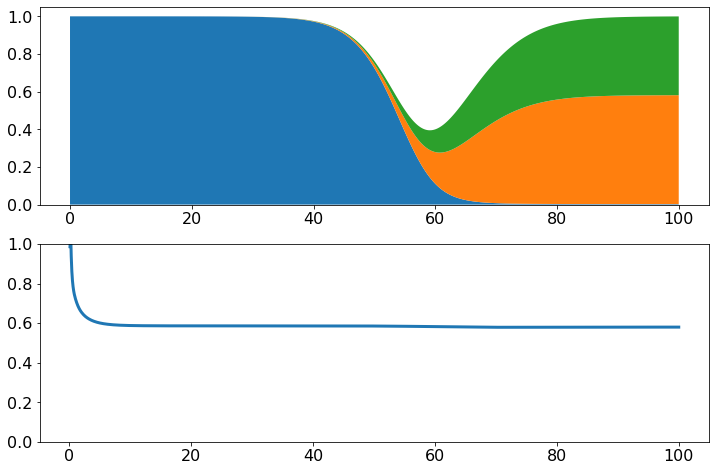

In [22]:
fig,(ax1,ax2) = plt.subplots(2,1)
# ax1.plot(sch1.result.t,sch1.result.Rp)
# ax1.plot(sch1.result.t,Rs)
ax1.stackplot(sch1.result.t,
        sch1.result.S,
        sch1.result.Rp,
        Rs
    )
ax2.plot(sch1.result.t,sch1.result.Rp/(sch1.result.Rp+Rs))

ax2.set_ylim([0,1])

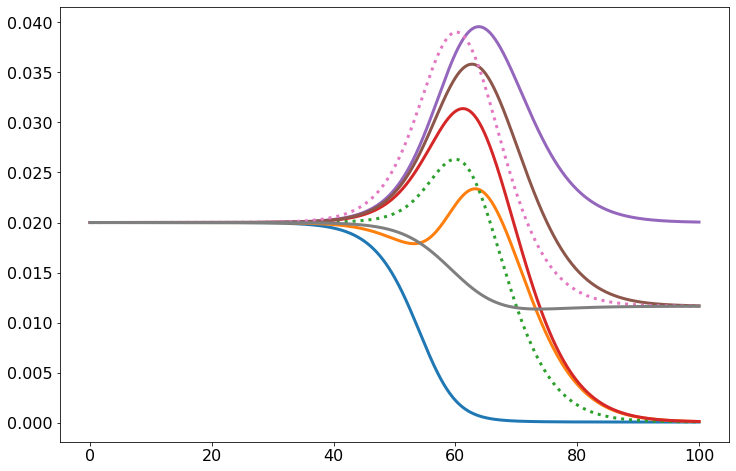

In [40]:
totSympTest = nu*cumtrapz(sch1.result.I,sch1.result.t) 
totSympTest2 = gamma*rho*cumtrapz(sch1.result.P,sch1.result.t) 

runSusTest = tau*sch1.result.S 
runNonRecTest = tau*(sch1.result.S + sch1.result.E1 + sch1.result.E2 + sch1.result.P)
runAllTest = tau*(sch1.result.S + sch1.result.E1 + sch1.result.E2 + sch1.result.P + sch1.result.Rp + Rs)
runAllPosTest = tau*(sch1.result.S + sch1.result.E1 + sch1.result.E2 + sch1.result.P + sch1.result.Rp )
runSympTest = nu*sch1.result.I 
runSympTest2 = gamma*rho*sch1.result.P

fig,ax1 = plt.subplots()
ax1.plot(sch1.result.t,runSusTest)
ax1.plot(sch1.result.t,runSusTest+runSympTest)
ax1.plot(sch1.result.t,runSusTest+runSympTest2,':')
ax1.plot(sch1.result.t,runNonRecTest+runSympTest)
ax1.plot(sch1.result.t,runAllTest+runSympTest)
ax1.plot(sch1.result.t,runAllPosTest+runSympTest)
ax1.plot(sch1.result.t,runAllPosTest+runSympTest2,':')
ax1.plot(sch1.result.t,runAllPosTest)

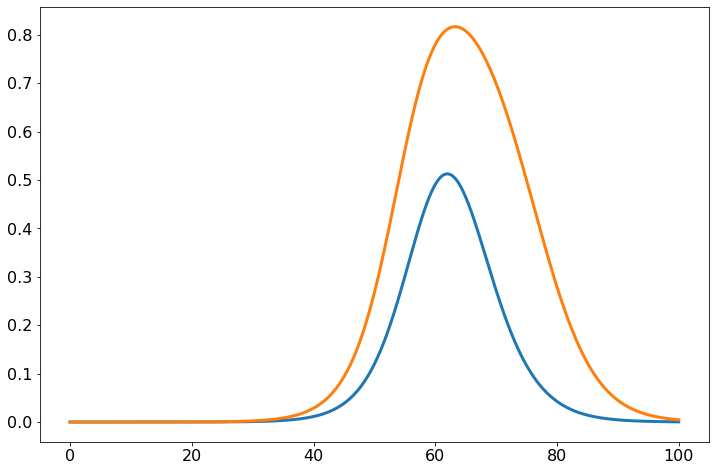

In [24]:
fig,ax1 = plt.subplots()
ax1.plot(sch1.result.t,tau*(sch1.result.E2+sch1.result.P+sch1.result.A)/(runAllPosTest))
ax1.plot(sch1.result.t,(runSympTest+tau*(sch1.result.E2+sch1.result.P+sch1.result.A))/(runSympTest+runAllPosTest))

(0.0, 1.8)

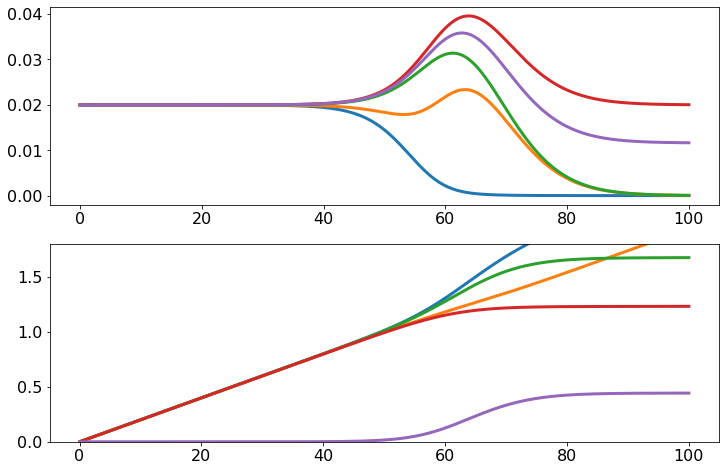

In [25]:
totSympTest = nu*cumtrapz(sch1.result.I,sch1.result.t) 

runSusTest = tau*sch1.result.S 
runNonRecTest = tau*(sch1.result.S + sch1.result.E1 + sch1.result.E2 + sch1.result.P)
runAllTest = tau*(sch1.result.S + sch1.result.E1 + sch1.result.E2 + sch1.result.P + sch1.result.Rp + Rs)
runAllPosTest = tau*(sch1.result.S + sch1.result.E1 + sch1.result.E2 + sch1.result.P + sch1.result.Rp )
runSympTest = nu*sch1.result.I 

fig,(ax1,ax2) = plt.subplots(2,1) 
ax1.plot(sch1.result.t,runSusTest)
ax1.plot(sch1.result.t,runSusTest+runSympTest)
ax1.plot(sch1.result.t,runNonRecTest+runSympTest)
ax1.plot(sch1.result.t,runAllTest+runSympTest)
ax1.plot(sch1.result.t,runAllPosTest+runSympTest)
# ax1.plot(sch1.result.t,tau+runSympTest)


ax2.plot(sch1.result.t[1:],cumtrapz(runAllTest+runSympTest,sch1.result.t))
ax2.plot(sch1.result.t[1:],cumtrapz(runAllTest,sch1.result.t))
ax2.plot(sch1.result.t[1:],cumtrapz(runNonRecTest+runSympTest,sch1.result.t))
ax2.plot(sch1.result.t[1:],cumtrapz(runNonRecTest,sch1.result.t))
ax2.plot(sch1.result.t[1:],cumtrapz(runSympTest,sch1.result.t))
# ax1.plot(sch1.result.t,totSusTest)
# ax1.plot(sch1.result.t[1:],totSusTest[1:]+totSympTest)
# ax2.plot(sch1.result.t[1:],cumtrapz(runAllTest+runSympTest)-20)
# ax2.plot(sch1.result.t[1:],cumtrapz(runAllTest)-20)
# ax2.plot(sch1.result.t[1:],cumtrapz(runNonRecTest+runSympTest)-20)

ax2.set_ylim(bottom=0,top=1.8)
# ax1.set_ylim(bottom=tau*0.9,top=tau*1.2)

In [26]:
totSympTest = nu*cumtrapz(sch1.result.I,sch1.result.t) 

runSusTest = tau*sch1.result.S 
runNonRecTest = tau*(sch1.result.S + sch1.result.E1 + sch1.result.E2 + sch1.result.P)
runAllTest = tau*(sch1.result.S + sch1.result.E1 + sch1.result.E2 + sch1.result.P + sch1.result.Rp + Rs)
runSympTest = nu*sch1.result.I 


totNonRecTest = cumtrapz(runNonRecTest,sch1.result.t)
totNonRecTest[-1]

1.2334762910243697

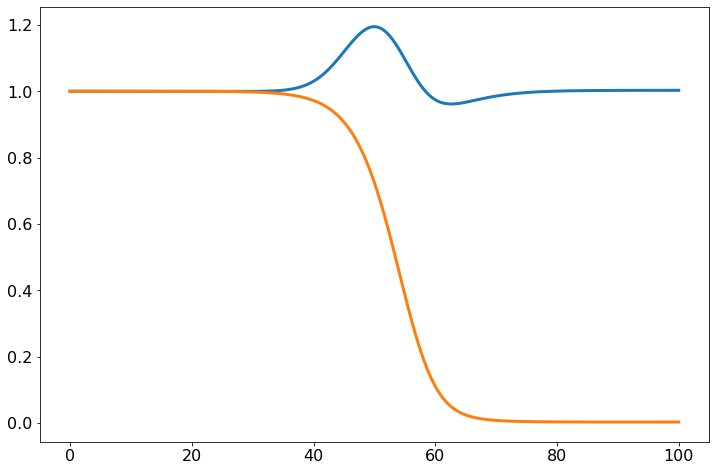

In [27]:
fig,ax1 = plt.subplots() 


sigma = sch1.result.S
estiTE = (1-sigma)/(gamma+tau)
estiTP = (1-sigma - tau*estiTE)/(gamma+tau)
estiTA = (1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau)

# ax1.plot(sch1.result.t,estiTE)
# ax1.plot(sch1.result.t,estiTP)
# ax1.plot(sch1.result.t,nu*estiTA)
# ax1.plot(sch1.result.t,1-sch1.result.S-nu*estiTA)
# ax1.plot(sch1.result.t,Rp)

# ax1.plot(sch1.result.S,Rp/(Rp+Rn))
ax1.plot(sch1.result.t,sch1.result.S+Rp+Rn)

# ax1.plot(sch1.result.t,Rp)
# ax1.plot(sch1.result.t,Rn+Rp)

# sigmat = sch1.result.S 

# ax1.set_yscale('log')

# ax1.set_ylim([0,0.5])

ax1.plot(sch1.result.t,sch1.result.S)

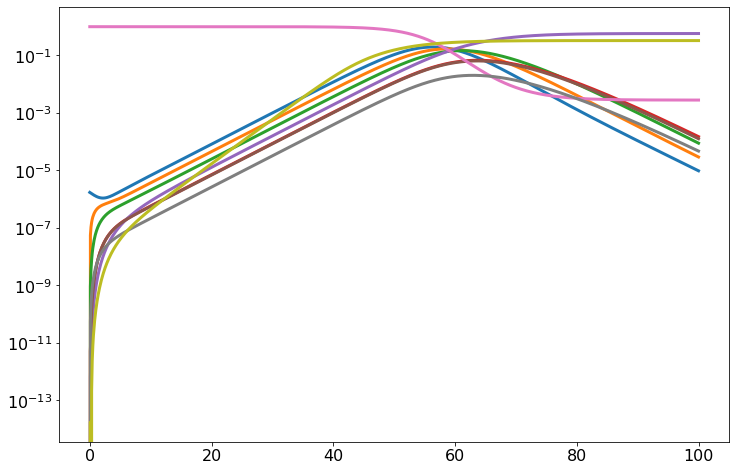

In [28]:
fig,ax1 = plt.subplots()

ax1.plot(sch1.result.t,sch1.result.E1)
ax1.plot(sch1.result.t,sch1.result.E2)
ax1.plot(sch1.result.t,sch1.result.P)
ax1.plot(sch1.result.t,sch1.result.I)
ax1.plot(sch1.result.t,sch1.result.Rp)
ax1.plot(sch1.result.t,sch1.result.A)
ax1.plot(sch1.result.t,sch1.result.S)
ax1.plot(sch1.result.t,sch1.result.Q)
ax1.plot(sch1.result.t,Rn)
# ax1.set_xlim([0,10])
# ax1.set_ylim([0,0.00001])
ax1.set_yscale('log')

In [29]:
gamma+tau
nu+tau

0.35333333333333333

In [30]:
Amat = np.array(
    [
        [-gamma,0,beta,0,beta],
        [gamma,-gamma-tau,0,0,0],
        [0,gamma,-gamma-tau,0,0],
        [0,0,gamma*rho,-nu,0],
        [0,0,gamma*(1-rho),0,-nu-tau]
    ]
)

# np.eig(Amat)
# np.eigenvect(Amat)
# Amat.eigenvalues
np.linalg.eig(Amat)

(array([-0.33333333+0.j       ,  0.25032092+0.j       ,
        -0.56414966+0.4894571j, -0.56414966-0.4894571j,
        -0.51535492+0.j       ]),
 array([[ 0.        +0.j        , -0.84138865+0.j        ,
          0.79713281+0.j        ,  0.79713281-0.j        ,
         -0.13230785+0.j        ],
        [ 0.        +0.j        , -0.46460848+0.j        ,
         -0.19723198-0.457918j  , -0.19723198+0.457918j  ,
          0.2722021 +0.j        ],
        [ 0.        +0.j        , -0.25655331+0.j        ,
         -0.21425343+0.22660232j, -0.21425343-0.22660232j,
         -0.56001199+0.j        ],
        [ 1.        +0.j        , -0.07326064+0.j        ,
          0.09126877+0.02991597j,  0.09126877-0.02991597j,
          0.51277066+0.j        ],
        [ 0.        +0.j        , -0.0708334 +0.j        ,
          0.09159259+0.03350588j,  0.09159259-0.03350588j,
          0.57606725+0.j        ]]))

In [31]:
# beta*gamma*gamma 

# ()


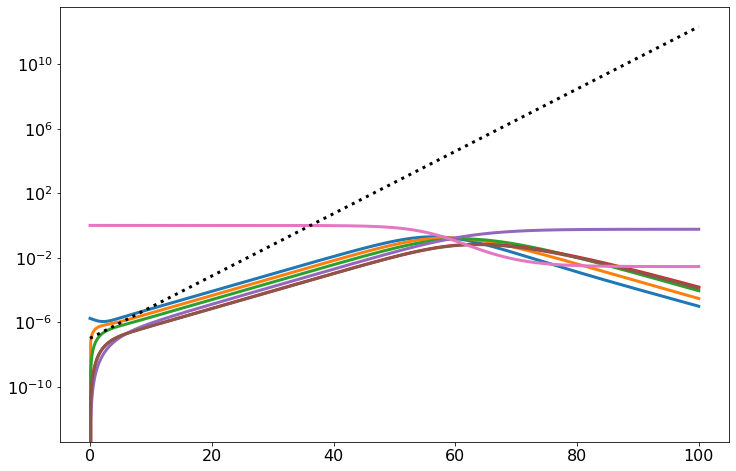

In [32]:
fig,ax1 = plt.subplots()

ax1.plot(sch1.result.t,sch1.result.E1)
ax1.plot(sch1.result.t,sch1.result.E2)
ax1.plot(sch1.result.t,sch1.result.P)
ax1.plot(sch1.result.t,sch1.result.I)
ax1.plot(sch1.result.t,sch1.result.Rp)
ax1.plot(sch1.result.t,sch1.result.A)
ax1.plot(sch1.result.t,sch1.result.S)

# ax1.set_xlim([0,30])
# ax1.set_ylim([0,0.0001])
ax1.set_yscale('log')
ax1.plot(sch1.result.t,0.0000001*np.exp(0.445*sch1.result.t),'k:')

# Old below

In [33]:

# print(f'Fraction found positive: {sch1.result.Rp[-1]:0.2f}')
# print(f'Fraction never positive: {Rs[-1]:0.2f}')
# print(f'Fraction ever sick: {1-sch1.result.S[-1]:0.2f}')
# # print(f'Fraction susceptible: {sch1.result.S[-1]:0.2f}')

# print(np.trapz(sch1.result.A,sch1.result.t)*nu)
# print(np.trapz(sch1.result.I,sch1.result.t)*nu)
# print(np.trapz(sch1.result.Q,sch1.result.t)*nu)

In [34]:
def simAndGetRatios(testProb,beta):
    pars = {'beta':beta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':testProb}
    # print(testProb)

    tEnd = 150 
    sch1 = pmf.Scheme(modelMeta_symp_rec,init,pars,0,tEnd,Changes=[])
    sch1.simulate(tRes=100)

    Rs = 1- sch1.result.y.sum(axis=0)

    return sch1.result.Rp[-1],(1-sch1.result.S[-1])

simAndGetRatios(0.4,2)

NameError: name 'sympRate' is not defined

In [ ]:
tauRange = np.linspace(0,0.6,40)

In [ ]:
tauRange = np.linspace(0,0.6,40)

sigmas = []
Rps = []
for testProb in tauRange:
    pars = {'beta':beta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':testProb}
    # print(testProb)

    tEnd = 150 
    sch1 = pmf.Scheme(modelMeta_symp_rec,init,pars,0,tEnd,Changes=[])
    sch1.simulate(tRes=100)

    sigmas.append(sch1.result.S[-1])
    Rps.append(sch1.result.Rp[-1])


sigmas = np.array(sigmas)
Rps = np.array(Rps)

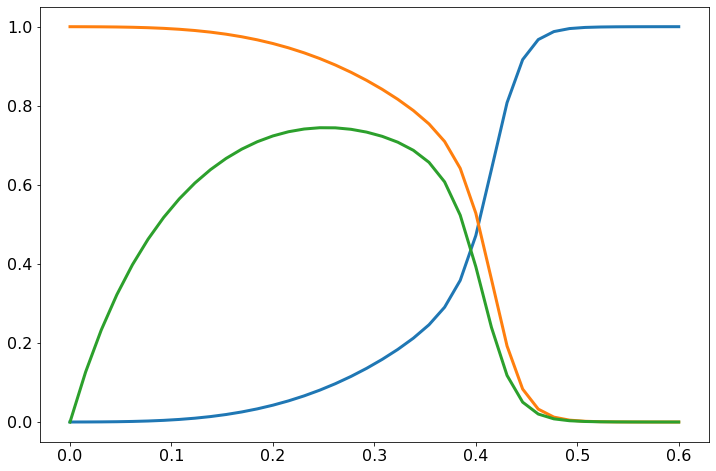

In [ ]:
fig,ax1 = plt.subplots()
ax1.plot(tauRange,sigmas)
ax1.plot(tauRange,1-sigmas)
ax1.plot(tauRange,Rps)

In [ ]:
# fig,ax1 = plt.subplots()

# ax1.plot(sigmas,Rps)

In [ ]:
testProb = tauRange[24]
pars = {'beta':beta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':testProb}
# print(testProb)

tEnd = 300 
sch1 = pmf.Scheme(modelMeta_symp_rec,init,pars,0,tEnd,Changes=[])
sch1.simulate(tRes=100)
Rs = 1- sch1.result.y.sum(axis=0)

sch1.result.S[-1]

0.2712295946768906

In [ ]:
def getBetaFromTauAndSigma(tau,sigma,pars):

    gamma = pars['gamma']
    nu = pars['nu']
    rho = pars['sympRate']

    estiTE = (1-sigma)/(gamma+tau)
    estiTP = (1-sigma - tau*estiTE)/(gamma+tau)
    estiTA = (1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau)

    beta = -np.log(sigma)/(estiTP+estiTA)
    

    return beta 


# print( getBetaFromTauAndSigma(pars['testProb'],sch1.result.S[-1],pars))

newTau = 0.5*pars['testProb']
newBeta =  getBetaFromTauAndSigma(0.5*pars['testProb'],sch1.result.S[-1],pars)

# pars['beta']

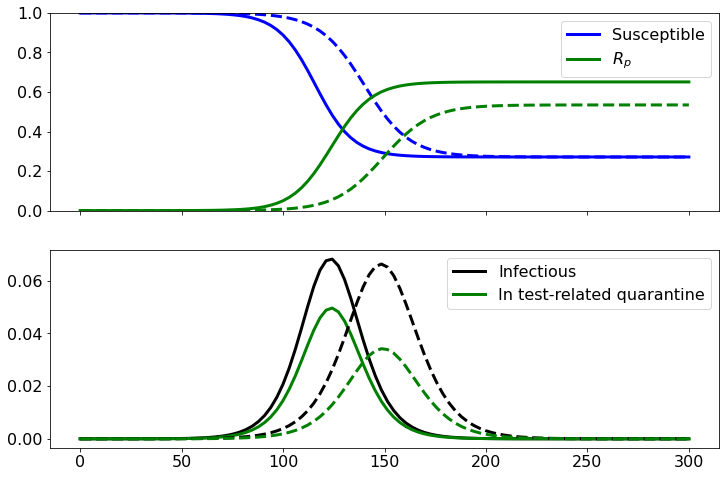

In [ ]:

pars2 = {'beta':newBeta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':newTau}
sch2 = pmf.Scheme(modelMeta_symp_rec,init,pars2,0,tEnd,Changes=[])
sch2.simulate(tRes=100)
Rs2 = 1- sch2.result.y.sum(axis=0)


fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(sch1.result.t,sch1.result.S,'b',label='Susceptible')
ax1.plot(sch2.result.t,sch2.result.S,'b--')
ax1.plot(sch1.result.t,sch1.result.Rp,'g',label=r'$R_p$')
ax1.plot(sch2.result.t,sch2.result.Rp,'g--')
# ax1.plot(sch1.result.t,Rs,'m',label=r'$R_n$')
# ax1.plot(sch1.result.t,Rs2,'m--')
ax1.set_ylim([0,1])

ax2.plot(sch1.result.t,sch1.result.A+sch1.result.I2+sch1.result.Q+sch1.result.I,'k',label='Infectious')
ax2.plot(sch1.result.t,sch1.result.Q,'g',label='In test-related quarantine')
ax2.plot(sch2.result.t,sch2.result.A+sch2.result.I2+sch2.result.Q+sch2.result.I,'k--')
ax2.plot(sch2.result.t,sch2.result.Q,'g--')


ax1.legend()
ax2.legend()

0.11675093184124799


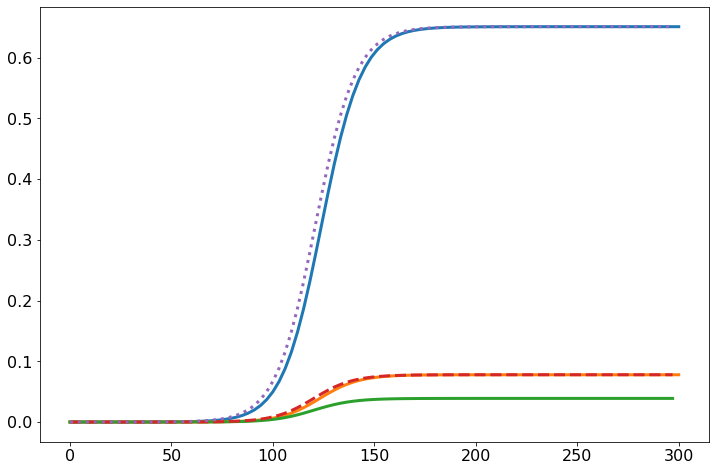

In [ ]:
sigma = sch1.result.S[-1]
tau = pars['testProb']
gamma = pars['gamma']
nu = pars['nu']
rho = pars['sympRate']

estiTE = (1-sigma)/(gamma+tau)
estiTP = (1-sigma - tau*estiTE)/(gamma+tau)
estiTA = (1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau)

print(estiTA)

fig,ax1 = plt.subplots()

# ax1.plot(sch1.result.t[:-1],cumtrapz(sch1.result.A,sch1.result.t))
# ax1.plot(sch1.result.t[:-1],cumtrapz(Rs,sch1.result.t))
ax1.plot(sch1.result.t,sch1.result.Rp)
ax1.plot(sch1.result.t,Rs)
# ax1.plot(sch1.result.t[:-1],nu*cumtrapz(sch1.result.A,sch1.result.t))
ax1.plot(sch1.result.t[:-1],nu*cumtrapz(sch1.result.A,sch1.result.t)+nu*cumtrapz(sch1.result.I2,sch1.result.t),'--')
ax1.plot(sch1.result.t[:-1],cumtrapz(sch1.result.Q,sch1.result.t)*nu,':')
# ax1.plot(sch1.result.t,sch1.result.Q)


In [ ]:
estiTA 

asdf = (nu/(nu+tau))*(1-tau/(gamma+tau))*(1-(gamma*rho+tau)/(gamma+tau))
print(1-asdf)
# estiTA*nu/(1-sigma)

# sch1.result.Rp[-1]
# Rs[-1]

curTI = np.trapz(sch1.result.I2,sch1.result.t)
curTA = np.trapz(sch1.result.A,sch1.result.t)
curTQ = np.trapz(sch1.result.Q,sch1.result.t)

print(curTQ*nu + nu*curTI )
print(curTA*nu)

rn = curTA*nu
rp = curTQ*nu + nu*curTI 
rp/(rp+rn)



0.946599125052064
0.6898534147128347
0.038916977258161525


0.9465991241042208

In [ ]:
tau = pars2['testProb']
gamma = pars2['gamma']
nu = pars2['nu']
rho = pars2['sympRate']

asdf2 = (nu/(nu+tau))*(1-tau/(gamma+tau))*(1-(gamma*rho+tau)/(gamma+tau))
print(1-asdf2)

curTI2 = np.trapz(sch2.result.I2,sch2.result.t)
curTA2 = np.trapz(sch2.result.A,sch2.result.t)
curTQ2 = np.trapz(sch2.result.Q,sch2.result.t)

# print(curTQ2*nu + nu*curTI2 )
# print(curTA2*nu)

rn2 = curTA2*nu
rp2 = curTQ2*nu + nu*curTI2 
rp2/(rp2+rn2)


0.8667258403126853


0.8667258242451092

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_20196\4126820573.py:11: RuntimeWarning: divide by zero encountered in log
  beta = -np.log(sigma)/(estiTP+estiTA)
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_20196\4126820573.py:11: RuntimeWarning: invalid value encountered in true_divide
  beta = -np.log(sigma)/(estiTP+estiTA)


Text(0, 0.5, 'Tau')

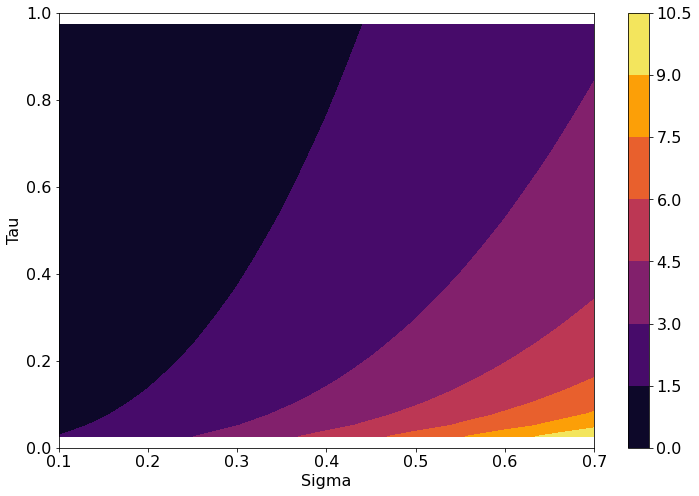

In [ ]:
sigmaRange = np.arange(0.1,0.71,0.05)
curTauRange = np.linspace(0,1,40)

curBetas = np.zeros(curTauRange.shape)

[XX,YY] = np.meshgrid(sigmaRange,curTauRange)
ZZ = getBetaFromTauAndSigma(XX,YY,pars)
ZZ

# fig,ax1 = plt.subplots(subplot_kw={"projection": "3d"})

# ax1.plot_surface(XX,YY,ZZ)


fig,ax1 = plt.subplots()
CS = ax1.contourf(XX,YY,ZZ,cmap='inferno')
fig.colorbar(CS)

ax1.set_xlabel('Sigma')
ax1.set_ylabel('Tau')

In [ ]:
finS = 0.27123
# newTauRange[1]


# newTau = newTauRange[0]
# newBeta =  getBetaFromTauAndSigma(newTau,finS,pars)
# newPars = {'beta':newBeta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':newTau}
# newSch = pmf.Scheme(modelMeta_symp_rec,init,newPars,0,tEnd,Changes=[])
# newSch.simulate(tRes=100)
# ax1.plot(newSch.result.t,newSch.result.S)



# newTau = newTauRange[1]
# newBeta =  getBetaFromTauAndSigma(newTau,finS,pars)
# newPars = {'beta':newBeta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':newTau}
# newSch = pmf.Scheme(modelMeta_symp_rec,init,newPars,0,tEnd,Changes=[])
# newSch.simulate(tRes=100)

# ax1.plot(newSch.result.t,newSch.result.S)



# newTau = newTauRange[2]
# newBeta =  getBetaFromTauAndSigma(newTau,finS,pars)
# newPars = {'beta':newBeta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':newTau}
# newSch = pmf.Scheme(modelMeta_symp_rec,init,newPars,0,tEnd,Changes=[])
# newSch.simulate(tRes=100)

# ax1.plot(newSch.result.t,newSch.result.S)


# # newTau = 0.5*pars['testProb']
# # newBeta =  getBetaFromTauAndSigma(0.5*pars['testProb'],sch1.result.S[-1],pars)

In [ ]:
# fig,ax1 = plt.subplots()
newTauRange = np.linspace(0.01,0.9,20)
newTauRange = np.linspace(0,1,20)
tEnd =300

newBetas = np.zeros(newTauRange.shape)
newSigmas = np.zeros(newTauRange.shape)
newRps = np.zeros(newTauRange.shape)

# for newTau in newTauRange:
for i,newTau in enumerate(newTauRange):

    newBeta =  getBetaFromTauAndSigma(newTau,finS,pars)
    newPars = {'beta':newBeta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':newTau}
    newSch = pmf.Scheme(modelMeta_symp_rec,init,newPars,0,tEnd,Changes=[])
    newSch.simulate(tRes=100)

    newBetas[i] = newBeta 
    newSigmas[i] = newSch.result.S[-1]
    newRps[i] = newSch.result.Rp[-1]
    # ax1.plot(newSch.result.t,newSch.result.S)


(0.0, 0.2)

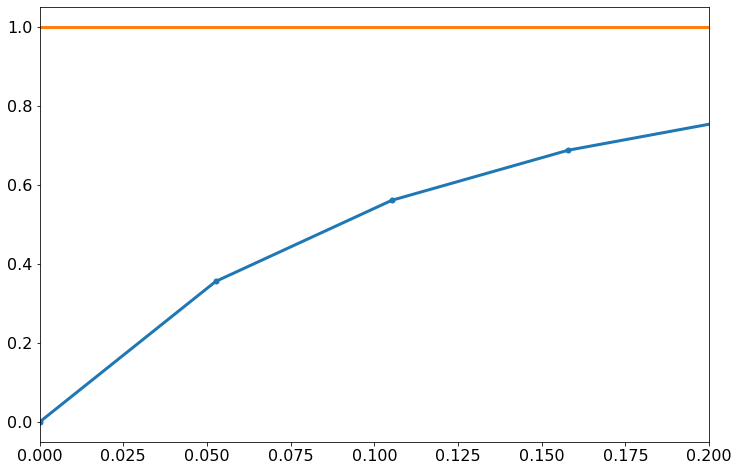

In [ ]:
fig,ax1 = plt.subplots()

# ax1.plot(newTauRange,newBetas)
# ax1.plot(newTauRange,newRps)
# ax1.plot(newTauRange,1-newSigmas)
ax1.plot(newTauRange,newRps/(1-newSigmas),'.-')
ax1.plot(newTauRange,(1-newSigmas)/(1-newSigmas))

ax1.set_xlim([0,0.2])

In [ ]:
# fig,ax1 = plt.subplots()
newTauRange = np.linspace(0.01,0.9,20)
newTauRange = np.linspace(0,1,20)
tEnd =300
finS = 0.2

newBetas = np.zeros(newTauRange.shape)
newSigmas = np.zeros(newTauRange.shape)
newRps = np.zeros(newTauRange.shape)

allResults = []

# for newTau in newTauRange:
for i,newTau in enumerate(newTauRange):

    newBeta =  getBetaFromTauAndSigma(newTau,finS,pars)
    newPars = {'beta':newBeta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':newTau}

    tEnd = 300
    newSch = pmf.Scheme(modelMeta_symp_rec,init,newPars,0,tEnd,Changes=[])
    newSch.simulate(tRes=100)

    newBetas[i] = newBeta 
    newSigmas[i] = newSch.result.S[-1]
    newRps[i] = newSch.result.Rp[-1]
    allResults.append(newSch.result)
    # ax1.plot(newSch.result.t,newSch.result.S)


In [ ]:
# fig,ax1 = plt.subplots()

# # ax1.plot(newTauRange,newRps)
# # ax1.plot(newTauRange,1-newSigmas)
# ax1.plot(newTauRange,newRps/(1-newSigmas),'.-')
# ax1.plot(newTauRange,(1-newSigmas)/(1-newSigmas))

# # ax1.set_xlim([0,0.2])

In [ ]:
# curRes.y
# ax_ins1.plot(curRes.t,curRes.S)
# ax_ins1.plot(curRes.t,curRes.Rp)
# ax_ins1.plot(curRes.t,curRes.Rp+curRn)

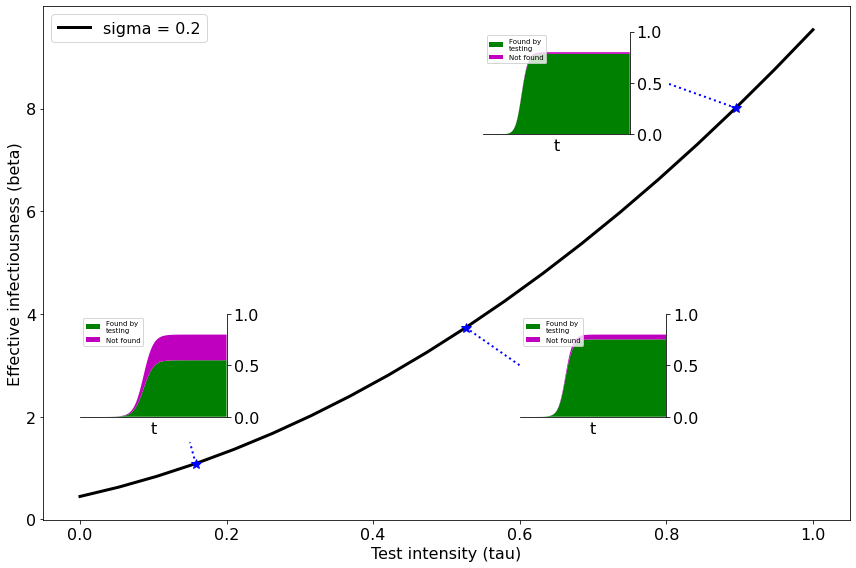

In [ ]:
fig,ax1 = plt.subplots() 
ax1.plot(newTauRange,newBetas,'k',label='sigma = 0.2')

ax1.plot(newTauRange[3],newBetas[3],'b*')
ax1.plot([newTauRange[3],0.15],[newBetas[3],1.5],'b:',linewidth=2)
ax_ins1 = ax1.inset_axes([0,2,0.2,2], transform=ax1.transData)
curRes = allResults[3]
curRn = 1- curRes.y.sum(axis=0)
ax_ins1.stackplot(curRes.t,curRes.Rp,curRn,colors=['g','m'],labels=['Found by\ntesting','Not found'])
ax_ins1.set_ylim([0,1])
ax_ins1.set_xlim([0,tEnd])
ax_ins1.set_yticks(np.arange(0,1.1,0.5))
ax_ins1.set_xticks([])
ax_ins1.yaxis.tick_right()
ax_ins1.spines['left'].set_visible(False)
ax_ins1.spines['top'].set_visible(False)
ax_ins1.set_xlabel('t')
ax_ins1.legend(loc='upper left',fontsize=7)

ax1.plot(newTauRange[-3],newBetas[-3],'b*')
ax1.plot([newTauRange[-3],0.8],[newBetas[-3],8.5],'b:',linewidth=2)
ax_ins1 = ax1.inset_axes([0.55,7.5,0.2,2], transform=ax1.transData)
curRes = allResults[-3]
curRn = 1- curRes.y.sum(axis=0)
ax_ins1.stackplot(curRes.t,curRes.Rp,curRn,colors=['g','m'],labels=['Found by\ntesting','Not found'])
ax_ins1.set_ylim([0,1])
ax_ins1.set_xlim([0,tEnd])
ax_ins1.set_yticks(np.arange(0,1.1,0.5))
ax_ins1.set_xticks([])
ax_ins1.yaxis.tick_right()
ax_ins1.spines['left'].set_visible(False)
ax_ins1.spines['top'].set_visible(False)
ax_ins1.set_xlabel('t')
ax_ins1.legend(loc='upper left',fontsize=7)


numVals = len(newTauRange)
ax1.plot(newTauRange[int(numVals/2)],newBetas[int(numVals/2)],'b*')
ax1.plot([newTauRange[int(numVals/2)],0.6],[newBetas[int(numVals/2)],3],'b:',linewidth=2)
ax_ins1 = ax1.inset_axes([0.6,2,0.2,2], transform=ax1.transData)
curRes = allResults[int(numVals/2)]
curRn = 1- curRes.y.sum(axis=0)
# ax_ins1.fill_between(curRes.t,np.ones(curRes.t.shape),color='xkcd:light gray',label='Susceptible')
ax_ins1.stackplot(curRes.t,curRes.Rp,curRn,colors=['g','m'],labels=['Found by\ntesting','Not found'])
ax_ins1.set_ylim([0,1])
ax_ins1.set_xlim([0,tEnd])
ax_ins1.set_yticks(np.arange(0,1.1,0.5))
ax_ins1.set_xticks([])
ax_ins1.yaxis.tick_right()
ax_ins1.spines['left'].set_visible(False)
ax_ins1.spines['top'].set_visible(False)
ax_ins1.set_xlabel('t')
ax_ins1.legend(loc='upper left',fontsize=7)

ax1.legend()
ax1.set_xlabel('Test intensity (tau)')
ax1.set_ylabel('Effective infectiousness (beta)')

fig.tight_layout()

if saveFigures:
    fig.savefig('Figures/TestingModelling_IsolineExamples')

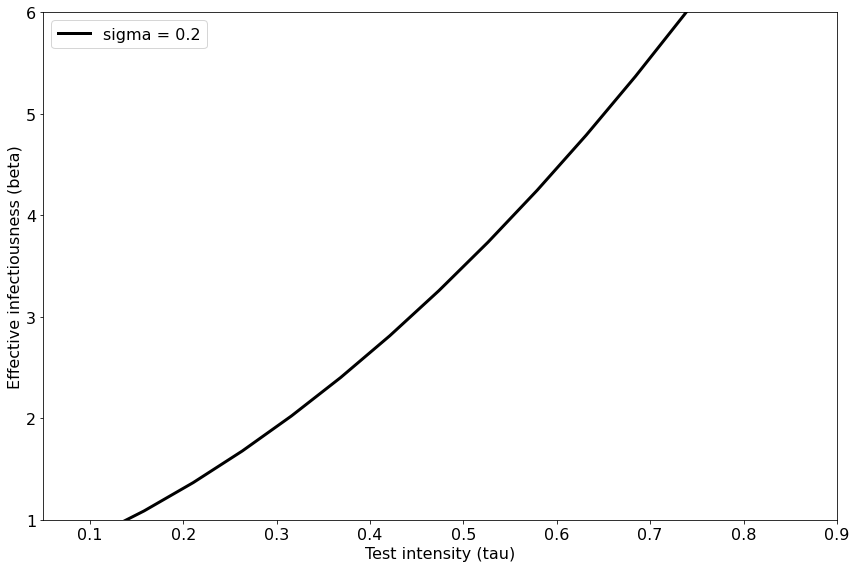

In [ ]:
fig,ax1 = plt.subplots() 
ax1.plot(newTauRange,newBetas,'k',label='sigma = 0.2')

ax1.set_xlim([0.05,0.9])
ax1.set_ylim([1,6])

ax1.legend()
ax1.set_xlabel('Test intensity (tau)')
ax1.set_ylabel('Effective infectiousness (beta)')

fig.tight_layout()

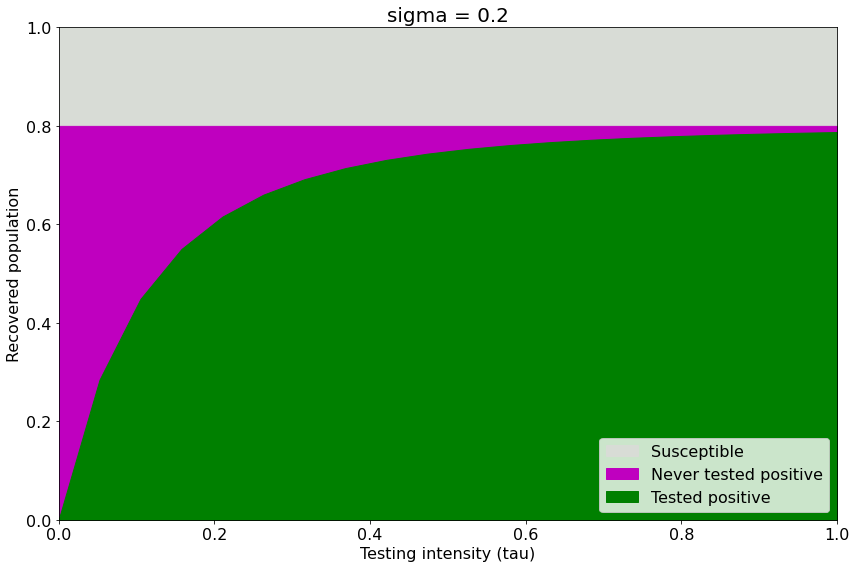

In [ ]:
fig,ax1 = plt.subplots()
# ax1.fill_between(newTauRange,(1-newSigmas)/(1-newSigmas),color='m')
# ax1.fill_between(newTauRange,newRps/(1-newSigmas),color='g')
ax1.fill_between(newTauRange,np.ones(newRps.shape),color='xkcd:light gray',label='Susceptible')
ax1.fill_between(newTauRange,(1-newSigmas),color='m',label='Never tested positive')
ax1.fill_between(newTauRange,newRps,color='g',label='Tested positive')

ax1.set_xlim([newTauRange[0],newTauRange[-1]])
ax1.set_ylim([0,1])

ax1.set_xlabel('Testing intensity (tau)')
ax1.set_ylabel('Recovered population')

ax1.legend(loc='lower right')

ax1.set_title(f'sigma = {finS}')

fig.tight_layout()

if saveFigures:
    fig.savefig('Figures/TestingModelling_AlongIsoline')

# asdf

array([1.66338422, 1.33588621, 1.15312198, 1.02995625, 0.93890065,
       0.86770887, 0.80990581, 0.76167437, 0.72058701, 0.68501059])

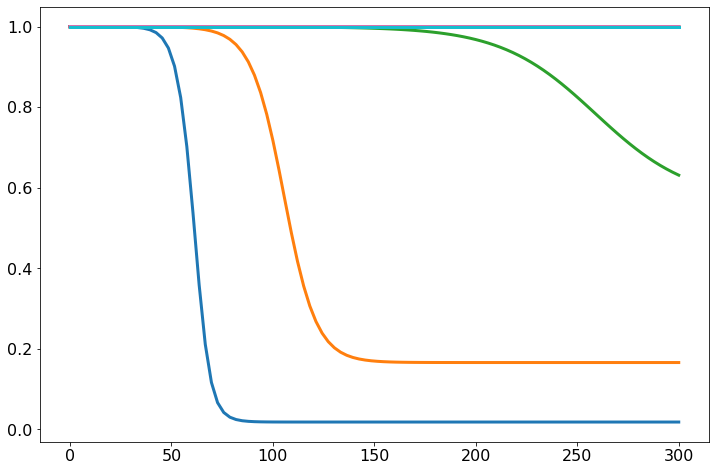

In [ ]:
# Try a range of taus

fig,ax1 = plt.subplots()

tauRange = np.linspace(0.1,0.9,10)

betas = []
sigmas = [] 
Rps = []
for tau in tauRange:
    curBeta = getBetaFromTauAndSigma(finS,tau,pars)
    pars = {'beta':curBeta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':tau}

    tEnd = 300
    sch1 = pmf.Scheme(modelMeta_symp_rec,init,pars,0,tEnd,Changes=[])
    sch1.simulate(tRes=100)

    Rps.append( sch1.result.Rp[-1] )
    sigmas.append( sch1.result.S[-1] )
    betas.append(curBeta)
    
    ax1.plot(sch1.result.t,sch1.result.S)

betas = np.array(betas)
sigmas = np.array(sigmas)
Rps = np.array(Rps)
betas

In [ ]:
sigmas

array([0.01804955, 0.16584228, 0.63125063, 0.999987  , 0.99999559,
       0.99999688, 0.99999739, 0.99999766, 0.99999782, 0.99999792])

In [ ]:
sigmas

array([0.01804955, 0.16584228, 0.63125063, 0.999987  , 0.99999559,
       0.99999688, 0.99999739, 0.99999766, 0.99999782, 0.99999792])

In [ ]:
# # def simAndGetRatios(testProb,beta):
# #     pars = {'beta':beta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':testProb}
# #     # print(testProb)

# #     tEnd = 150 
# #     sch1 = pmf.Scheme(modelMeta_symp_rec,init,pars,0,tEnd,Changes=[])
# #     sch1.simulate(tRes=100)

# #     Rs = 1- sch1.result.y.sum(axis=0)

# #     return sch1.result.Rp[-1],(1-sch1.result.S[-1])

# # simAndGetRatios(0.4,2)

# sigmas = [] 
# # for i in range(len(tauRange)):
# #     simAndGetRatios()
    
# simAndGetRatios(tauRange[1],betas[1]) 

In [ ]:
tau = testProb 
rho = sympRate

Ke = np.trapz(sch1.result.E2,sch1.result.t)
Kp = np.trapz(sch1.result.I,sch1.result.t)
Ka = np.trapz(sch1.result.A,sch1.result.t)
Ki = np.trapz(sch1.result.I2,sch1.result.t)

finS = sch1.result.S[-1]

estiKE = (1-finS)/(gamma+tau)
print(Ke)
print(estiKE)


estiKP = (1-finS - tau*estiKE)/(gamma+tau)
print(Kp)
print(estiKP)

estiKA = (1-finS - (gamma*rho+tau)*estiKP - tau*estiKE)/(nu+tau)
print(Ka)
print(estiKA)



1.3481731070887526e-06
2.958121030779261e-06
4.258390171710155e-07
1.4034880802967298e-06
5.639529823399969e-08
3.3294425262513666e-07


In [ ]:
tau = tauRange[10]
finS = sigmas[10]

rho = sympRate 


p1 = (nu+tau)/nu
p2 = (gamma*rho + 2*tau)/gamma 
p3 = (gamma*(1-rho) + 2*tau)/gamma 


Ti = np.trapz(sch1.result.I2,sch1.result.t)*nu
Ta = np.trapz(sch1.result.A,sch1.result.t)*nu
Tp = np.trapz(sch1.result.I,sch1.result.t)*gamma

1 - p1 * Ta - p2 * Tp 
# np.trapz(sch1.result.A,sch1.result.t)
# sch1.result.S

# plt.figure()
# plt.plot(sch1.result.t,sch1.result.S)
# plt.plot(sch1.result.t,sch1.result.Rp)
# plt.plot(sch1.result.t,sch1.result.Rp+Rs) 

np.trapz(sch1.result.I,sch1.result.t)*nu
# sch1.result.
# sch1.result.S[-1]

(beta/gamma) * Tp + (beta/nu) * Ta

np.log(finS)

1 - p1 * Ta - p2*Tp
1 - p1 * Ti - p3*Tp

Te = np.trapz(sch1.result.E2,sch1.result.t)*gamma 
print(Te)
print(Tp)



# TotP = (gamma/(gamma*(1-rho)+2*tau))*(1-((nu+tau)/nu)*TotI - finS)
# print(TotP/gamma)

# TotA = (nu/(nu+tau)) * (1-((gamma*rho+2*tau)/gamma)*TotP - finS)
# print(TotA/nu)

# foundBeta = -np.log(finS)/((TotP/gamma)+(TotA/nu))

# foundBeta

IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
 
p1 = (nu+tau)/nu
p2 = (gamma*rho + tau)/gamma 
p3 = (gamma*(1-rho) + tau)/gamma 
p4 = tau/gamma 
1 - p1 * Ta - p2*Tp - p4*Te


1-((gamma+tau)/gamma) * Te 




0.016633625537289087

In [ ]:
a1 = (nu+tau)/nu 
a2 = (gamma*rho + tau)/gamma 
a4 = tau/gamma 




Ta = np.trapz(sch1.result.A,sch1.result.t)*nu
Tp = np.trapz(sch1.result.I,sch1.result.t)*gamma
Te = np.trapz(sch1.result.E2,sch1.result.t)*gamma 
Ti = np.trapz(sch1.result.I2,sch1.result.t)*nu


estiTE = (1/(1+a4))*(1-finS)
Te

# estiTP = (1-finS-a1*)

(-np.log(finS) - (beta/a2*gamma)*(1-finS - a4*estiTE))/((beta/nu)-(beta*a1/(gamma*a2)))
Ta

print(finS)
# 1-a1*Ta-a2*Tp - a4*Te

# 1-((gamma+tau)/gamma)*Te

# 1 - ((gamma+tau)/gamma)*Tp - (tau/gamma)*Te
# 1 - ((nu+tau)/nu) *Ta - ((gamma*rho+tau)/gamma)*Tp -(tau/gamma)*Te


1 - a1*Ta - a2*Tp - a4*Te 
1 - a1*Ta - a2*Tp - a4*estiTE 

a3 = (gamma+tau)/gamma 

1 - a3*Tp - a4*estiTE 

# print(Tp)
estiTP = (1-finS -a4 * estiTE)/a3


# print(Ta)
estiTA =  (1-finS - a2*estiTP - a4*estiTE)/a1 

# Te
# gamma*(1-finS)/(gamma+tau)
# gamma/(gamma+tau)
# 1/(1+a4)


a22 = (gamma*(1-rho) + tau)/gamma 

# print(Ti)
estiTI =  (1-finS - a22*estiTP - a4*estiTE)/a1  

0.016633572196007775


In [ ]:
tau = tauRange[10]
tau = tauRange[20]
curTauIndex = 20
tau = tauRange[curTauIndex]
tau

0.30769230769230765

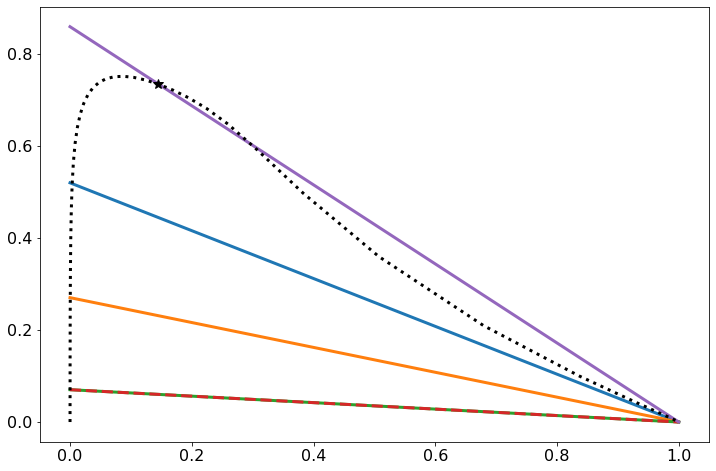

In [ ]:
finSrange = np.linspace(0,1,50)

TEs = []
TPs = []
TAs = []
TIs = []


for finS in finSrange:

    a1 = (nu+tau)/nu 
    a2 = (gamma*rho + tau)/gamma 
    a3 = (gamma+tau)/gamma 
    a4 = tau/gamma 
    a22 = (gamma*(1-rho) + tau)/gamma 


    estiTE = (1/(1+a4))*(1-finS)
    estiTP = (1-finS -a4 * estiTE)/a3
    estiTA = (1-finS - a2*estiTP - a4*estiTE)/a1 
    estiTI = (1-finS - a22*estiTP - a4*estiTE)/a1  

    TEs.append(estiTE)
    TPs.append(estiTP)
    TAs.append(estiTA)
    TIs.append(estiTI)

plt.figure()
plt.plot(finSrange,TEs)
plt.plot(finSrange,TPs)
plt.plot(finSrange,TAs)
plt.plot(finSrange,TIs,'--')

estiRPs = 1 - finSrange - TAs - TIs 
plt.plot(finSrange,estiRPs)
plt.plot(sigmas[curTauIndex],Rps[curTauIndex],'k*')
plt.plot(sigmas,Rps,'k:')

# plt.xlim([0,0.1])
# plt.ylim([0.6,0.7])

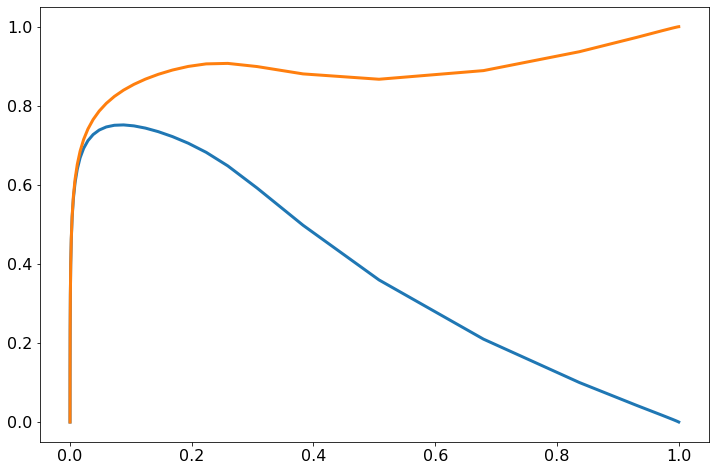

In [ ]:
plt.figure()
plt.plot(sigmas,Rps)
plt.plot(sigmas,sigmas+Rps)

In [ ]:
finS = 0.2 
finS = sigmas[curTauIndex]
tau = tauRange[curTauIndex]
a1 = (nu+tau)/nu 
a2 = (gamma*rho + tau)/gamma 
a3 = (gamma+tau)/gamma 
a4 = tau/gamma 
a22 = (gamma*(1-rho) + tau)/gamma 


estiTE = (1/(1+a4))*(1-finS)
estiTP = (1-finS -a4 * estiTE)/a3
estiTA = (1-finS - a2*estiTP - a4*estiTE)/a1 
estiTI = (1-finS - a22*estiTP - a4*estiTE)/a1  

print(beta)
-np.log(finS)/((estiTP/gamma) + (estiTA/nu))

2.21


2.2095363545201234

In [ ]:

finS = sigmas[curTauIndex]
tau = tauRange[curTauIndex]
# tau = 0.9
a1 = (nu+tau)/nu 
a2 = (gamma*rho + tau)/gamma 
a3 = (gamma+tau)/gamma 
a4 = tau/gamma 
a22 = (gamma*(1-rho) + tau)/gamma 


estiTE = (1/(1+a4))*(1-finS)
estiTP = (1-finS -a4 * estiTE)/a3
estiTA = (1-finS - a2*estiTP - a4*estiTE)/a1 
estiTI = (1-finS - a22*estiTP - a4*estiTE)/a1  

print(beta)
betaEsti = -np.log(finS)/((estiTP/gamma) + (estiTA/nu))
betaEsti

2.21


2.2095363545201234

In [ ]:
# testProb = tauRange[10]
pars = {'beta':betaEsti,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':tau}
# print(testProb)

tEnd = 200 
sch1 = pmf.Scheme(modelMeta_symp_rec,init,pars,0,tEnd,Changes=[])
sch1.simulate(tRes=100)
Rs = 1- sch1.result.y.sum(axis=0)

sch1.result.S[-1]

0.1450201819566206

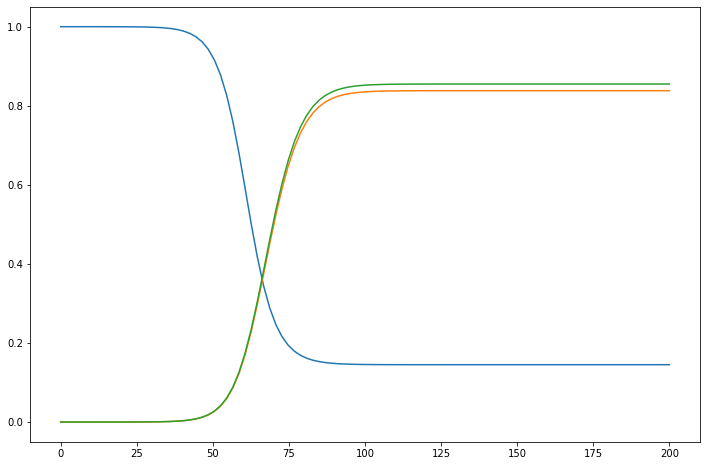

In [ ]:


fig,ax1 = plt.subplots()
ax1.plot(sch1.result.t,sch1.result.S)
ax1.plot(sch1.result.t,sch1.result.Rp)
ax1.plot(sch1.result.t,sch1.result.Rp+Rs)

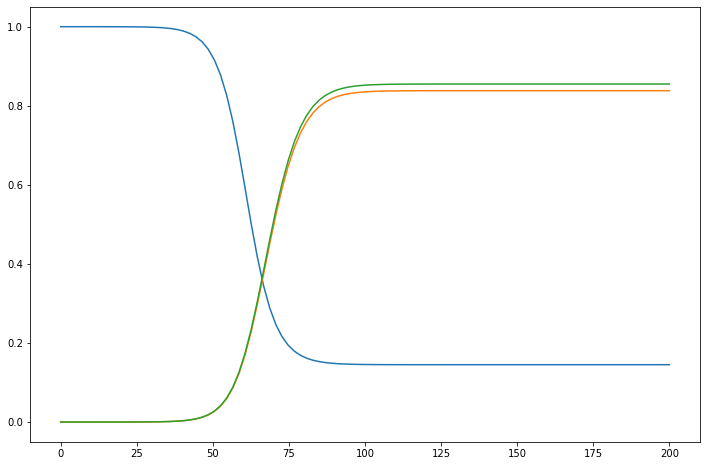

In [ ]:


fig,ax1 = plt.subplots()
ax1.plot(sch1.result.t,sch1.result.S)
ax1.plot(sch1.result.t,sch1.result.Rp)
ax1.plot(sch1.result.t,sch1.result.Rp+Rs)

In [ ]:
# testProbRange = np.linspace(1/2,1/10,10)
# betaRange = np.linspace(1,4,10)

# fig,ax1 = plt.subplots() 

# testProb = 0.95*1/7
# for i,curBeta in enumerate(betaRange):
#     if (i%4)==0:
#         print(i)
#     Rps,Rts = simAndGetRatios(testProb,curBeta)

#     ax1.plot(curBeta,Rps,'b*')
#     ax1.plot(curBeta,Rts,'m.')

# ax1.set_ylim([0,1])

# nu*gamma/(nu+gamma)
# (beta/nu) + (beta/gamma)

In [ ]:
# def testFunc(a,b):
#     return b*np.sin(a) 
# def helperFunc(a,b):
#     x,y = simAndGetRatios(a,b)
#     return y


# @np.vectorize
# def func(a,b):
#     return helperFunc(a,b)

# func([4,2],[1,2])

# @np.vectorize
# def helperFunc(a,b):
#     x,y = simAndGetRatios(a,b)
#     return y
    
# @np.vectorize
# def helperFunc2(a,b):
#     x,y = simAndGetRatios(a,b)
#     return x
    
@np.vectorize
def helperFunc(a,b):
    x,y = simAndGetRatios(a,b)
    return x,y



In [ ]:
# testProbRange = np.linspace(0.8,1/15,40)
# betaRange = np.linspace(1,5,40)
testProbRange = np.linspace(0.9,1/15,30)
betaRange = np.linspace(1,6,30)
# testProbRange = np.linspace(0,0.3,5)
# betaRange = np.linspace(0.2,2.5,5)
XX,YY = np.meshgrid(testProbRange,betaRange)
# ZZ = testFunc(XX,YY)
# ZZ = func(XX,YY)
ZZ = helperFunc(XX,YY)
# ZZ
# ZZ2 = helperFunc2(XX,YY)
# ZZ2
# asdf

In [ ]:
saveFigures = True

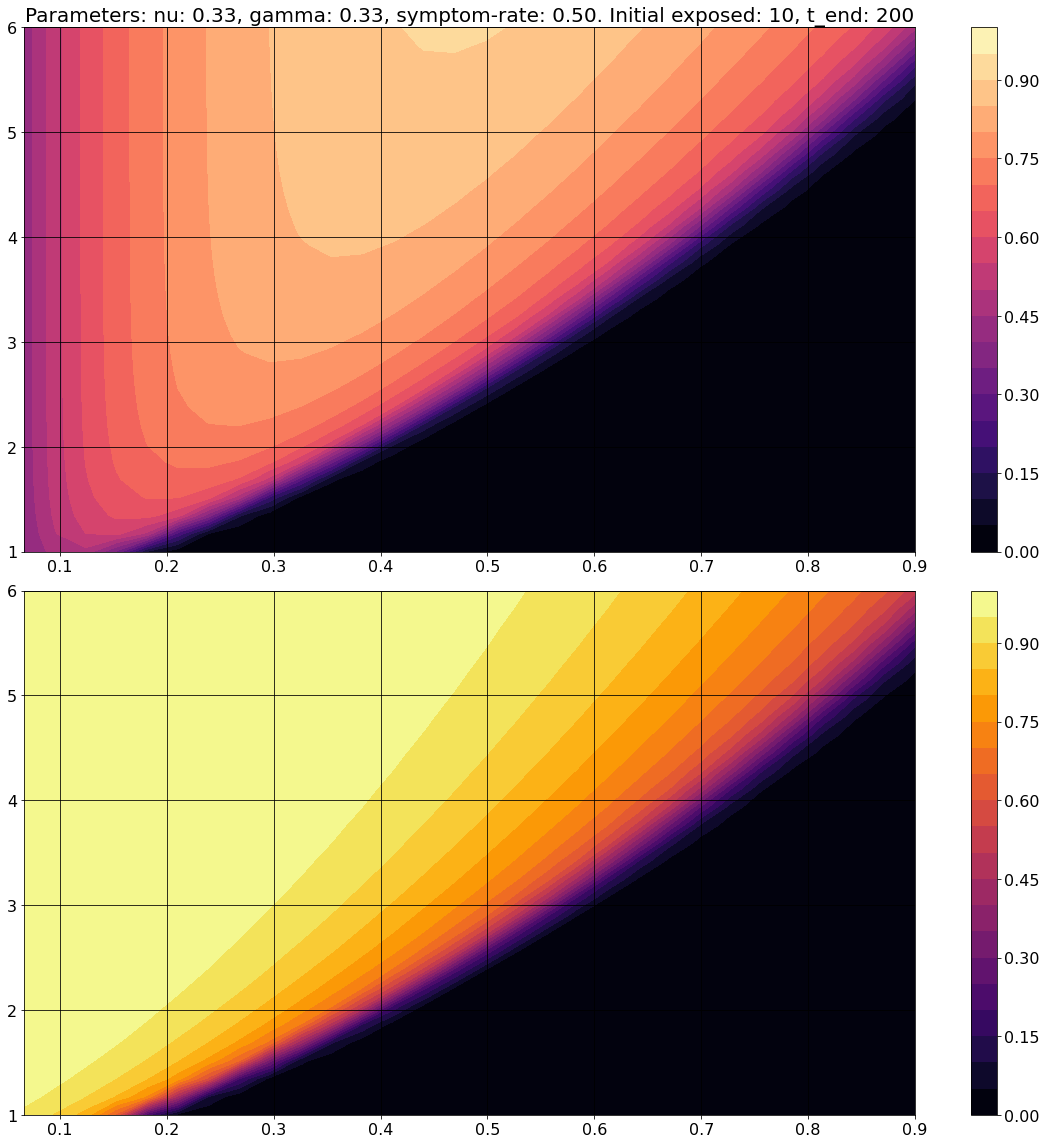

In [ ]:
# plt.figure() 
# plt.contourf(XX,YY,ZZ[0])
# plt.colorbar()
# fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,20))
# fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,20))
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,16))
CS = ax1.contourf(XX,YY,ZZ[0],cmap='magma',levels=np.arange(0,1.05,0.05))
fig.colorbar(CS, ax=ax1)
CS2 = ax2.contourf(XX,YY,ZZ[1],cmap='inferno',levels=np.arange(0,1.05,0.05))
fig.colorbar(CS2, ax=ax2)
# CS3 = ax3.contourf(XX,YY,ZZ[1]-ZZ[0])
# fig.colorbar(CS3, ax=ax3)

ax1.grid(color='k')
ax2.grid(color='k') 

topLabel = f'Parameters: nu: {nu:0.2f}, gamma: {gamma:0.2f}, symptom-rate: {sympRate:0.2f}. Initial exposed: {iniExp:2.0f}, t_end: {tEnd}'
ax1.set_title(topLabel)

fig.tight_layout()
if saveFigures:
    fig.savefig('Figures/TestingModelling_TestProbAndInfectivity_Split')

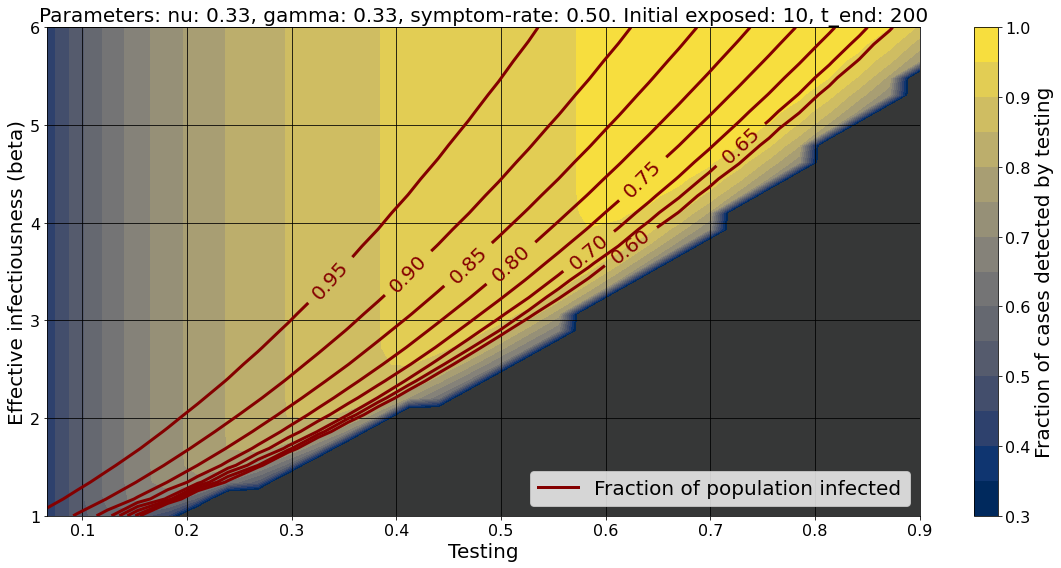

In [ ]:

# fig,ax1 = plt.subplots(figsize=(20,10))
fig,ax1 = plt.subplots(figsize=(16,8))
ax1.set_facecolor('xkcd:dark gray')
# CS = ax1.contourf(XX,YY,ZZ[0],levels=np.linspace(0.5,0.9,10),cmap='inferno')
# CS = ax1.contourf(XX,YY,(ZZ[1]>0.4)*ZZ[0]/ZZ[1],levels=np.arange(0.3,1.05,0.05),cmap='cividis')
CS = ax1.contourf(XX,YY,(ZZ[1]>0.2)*ZZ[0]/ZZ[1],levels=np.arange(0.3,1.01,0.05),cmap='cividis')
# CS = ax1.contourf(XX,YY,ZZ[0]/ZZ[1],levels=np.arange(0.3,1.01,0.05),cmap='cividis')
cbar = fig.colorbar(CS, ax=ax1)
cbar.set_label('Fraction of cases detected by testing',fontsize=20)
blackcmap = pf.getColormapFromList(['xkcd:dark red','xkcd:dark red'],20)
CS2 = ax1.contour(XX,YY,ZZ[1],levels=np.arange(0.6,1,0.05),cmap=blackcmap)
ax1.clabel(CS2,CS2.levels,inline=True,fontsize=20)

ax1.set_xlabel('Testing',fontsize=20)
ax1.set_ylabel('Effective infectiousness (beta)',fontsize=20)

ax1.grid(color='k')

# CS2.collections[4].set_label('Fraction of population infected')
# plt.legend()

ax1.plot((XX[0][0],XX[0][0]),(YY[0][0],YY[0][0]),color='xkcd:dark red',label='Fraction of population infected')
ax1.legend(loc='lower right',fontsize=20)

topLabel = f'Parameters: nu: {nu:0.2f}, gamma: {gamma:0.2f}, symptom-rate: {sympRate:0.2f}. Initial exposed: {iniExp:2.0f}, t_end: {tEnd}'
ax1.set_title(topLabel)

fig.tight_layout()

if saveFigures:
    fig.savefig('Figures/TestingModelling_TestProbAndInfectivity')


In [ ]:
0.6,4.5
0.18,1.26
0.2,1.35
0.44,3
0.4,2.66

plt.close('all')

asdfqwer

NameError: name 'asdfqwer' is not defined

In [ ]:
# testProb = 0.5
# beta = 2.5

# testProb = 0.18
# beta = 1.26

testProb1 = 0.2
beta = 1.33
pars = {'beta':beta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':testProb1}
tEnd = 200 
sch1 = pmf.Scheme(modelMeta_symp_rec,init,pars,0,tEnd,Changes=[])
sch1.simulate(tRes=1000)

Rs1 = 1- sch1.result.y.sum(axis=0)


# testProb2 = 0.44
# beta = 3
testProb2 = 0.4
beta = 2.66
pars = {'beta':beta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':testProb2}
sch2 = pmf.Scheme(modelMeta_symp_rec,init,pars,0,tEnd,Changes=[])
sch2.simulate(tRes=1000)

Rs2 = 1- sch2.result.y.sum(axis=0)

testProb3 = 0.6
beta = 4.5
pars = {'beta':beta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':testProb3} 
sch3 = pmf.Scheme(modelMeta_symp_rec,init,pars,0,tEnd,Changes=[])
sch3.simulate(tRes=1000)
Rs3 = 1- sch3.result.y.sum(axis=0)

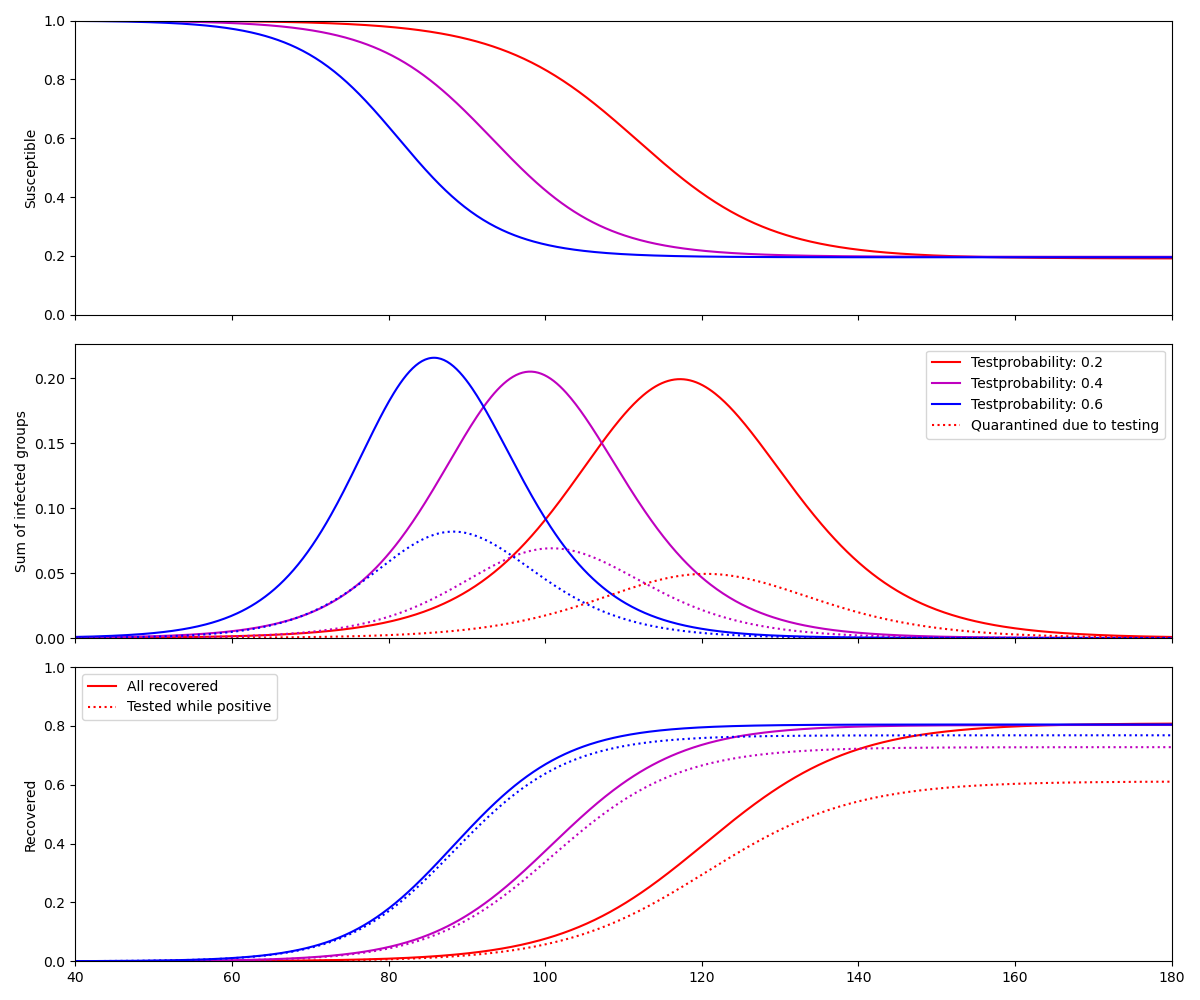

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(12,10))
ax1.plot(sch1.result.t,sch1.result.S,'r')
ax1.plot(sch2.result.t,sch2.result.S,'m')
ax1.plot(sch3.result.t,sch3.result.S,'b')
ax2.plot(sch1.result.t,1-sch1.result.S-sch1.result.Rp-Rs1,'r',label=f'Testprobability: {testProb1}')
ax2.plot(sch2.result.t,1-sch2.result.S-sch2.result.Rp-Rs2,'m',label=f'Testprobability: {testProb2}')
ax2.plot(sch3.result.t,1-sch3.result.S-sch3.result.Rp-Rs3,'b',label=f'Testprobability: {testProb3}')
ax2.plot(sch1.result.t,sch1.result.Q,'r:',label='Quarantined due to testing')
ax2.plot(sch2.result.t,sch2.result.Q,'m:')
ax2.plot(sch3.result.t,sch3.result.Q,'b:')
# ax2.plot(sch1.result.t,sch1.result.I2,'r--',label='Quarantined due to symptoms')
# ax2.plot(sch2.result.t,sch2.result.I2,'m--')
# ax2.plot(sch3.result.t,sch3.result.I2,'b--')



ax3.plot(sch1.result.t,sch1.result.Rp+Rs1,'r',label='All recovered')
ax3.plot(sch1.result.t,sch1.result.Rp,'r:',label='Tested while positive')
ax3.plot(sch2.result.t,sch2.result.Rp+Rs2,'m')
ax3.plot(sch2.result.t,sch2.result.Rp,'m:')
ax3.plot(sch3.result.t,sch3.result.Rp+Rs3,'b')
ax3.plot(sch3.result.t,sch3.result.Rp,'b:')


ax1.set_ylabel('Susceptible')
ax2.set_ylabel('Sum of infected groups')
ax3.set_ylabel('Recovered')

ax2.legend()
ax3.legend(loc='upper left')

ax1.set_xlim(left=0,right=tEnd)
ax1.set_xlim([40,180])

ax1.set_ylim([0,1])
ax2.set_ylim(bottom=0)
ax3.set_ylim([0,1])

fig.tight_layout()

In [ ]:
# testProb = 0.5
# beta = 2.5

testProb = 0.15
beta = 1.25
pars = {'beta':beta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':testProb}
tEnd = 300 
sch1 = pmf.Scheme(modelMeta_symp_rec,init,pars,0,tEnd,Changes=[])
sch1.simulate(tRes=1000)

Rs1 = 1- sch1.result.y.sum(axis=0)


testProb = 0.5
beta = 3.8
pars = {'beta':beta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':testProb}
tEnd = 300 
sch2 = pmf.Scheme(modelMeta_symp_rec,init,pars,0,tEnd,Changes=[])
sch2.simulate(tRes=1000)

Rs2 = 1- sch2.result.y.sum(axis=0)

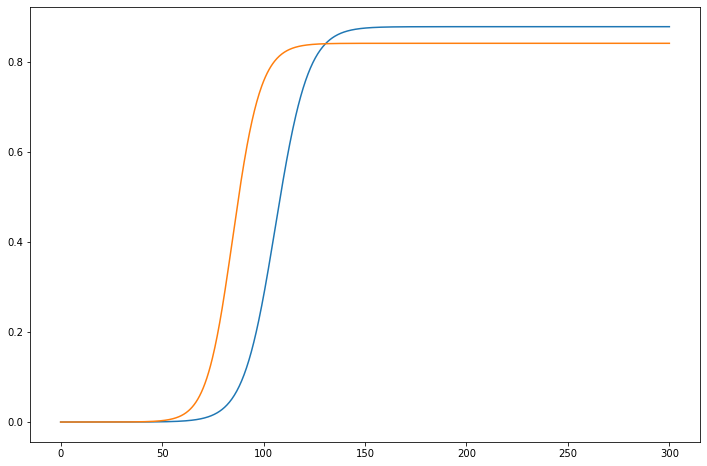

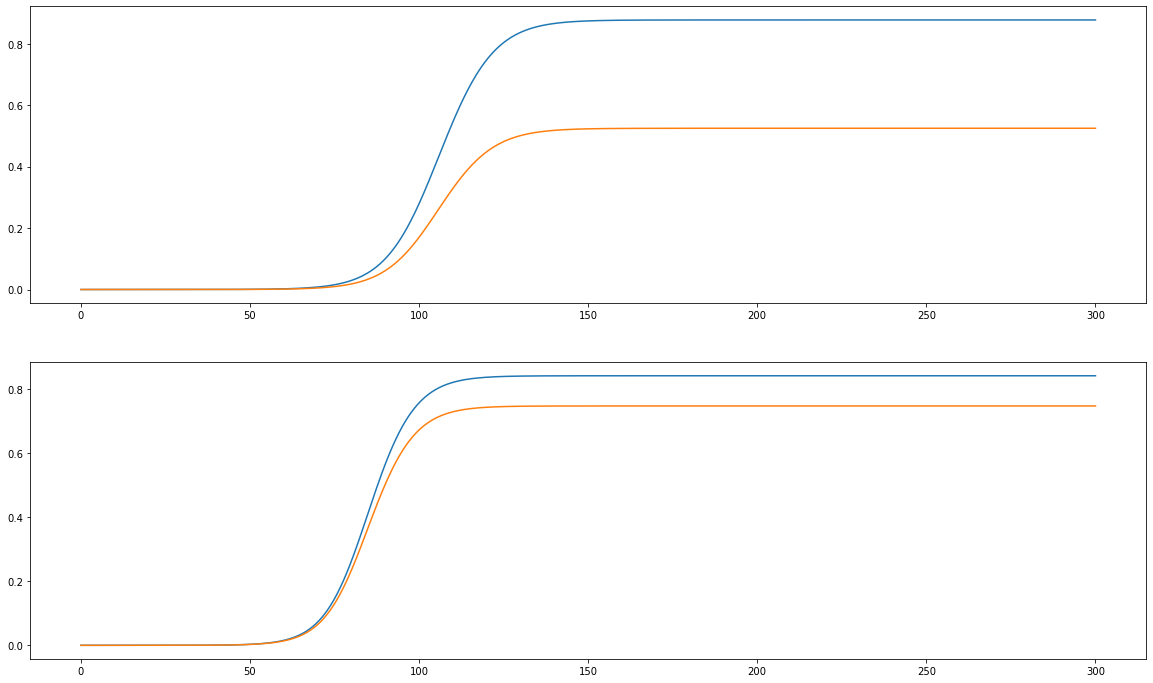

In [ ]:
fig,ax1 = plt.subplots()

ax1.plot(sch1.result.t,Rs1+sch1.result.Rp)
ax1.plot(sch2.result.t,Rs2+sch2.result.Rp)

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,12)) 

ax1.plot(sch1.result.t,Rs1+sch1.result.Rp)
ax1.plot(sch1.result.t,sch1.result.Rp)
# ax1.plot(sch1.result.t,Rs1)
ax2.plot(sch2.result.t,Rs2+sch2.result.Rp)
ax2.plot(sch2.result.t,sch2.result.Rp)
# ax2.plot(sch2.result.t,Rs2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 1.0)

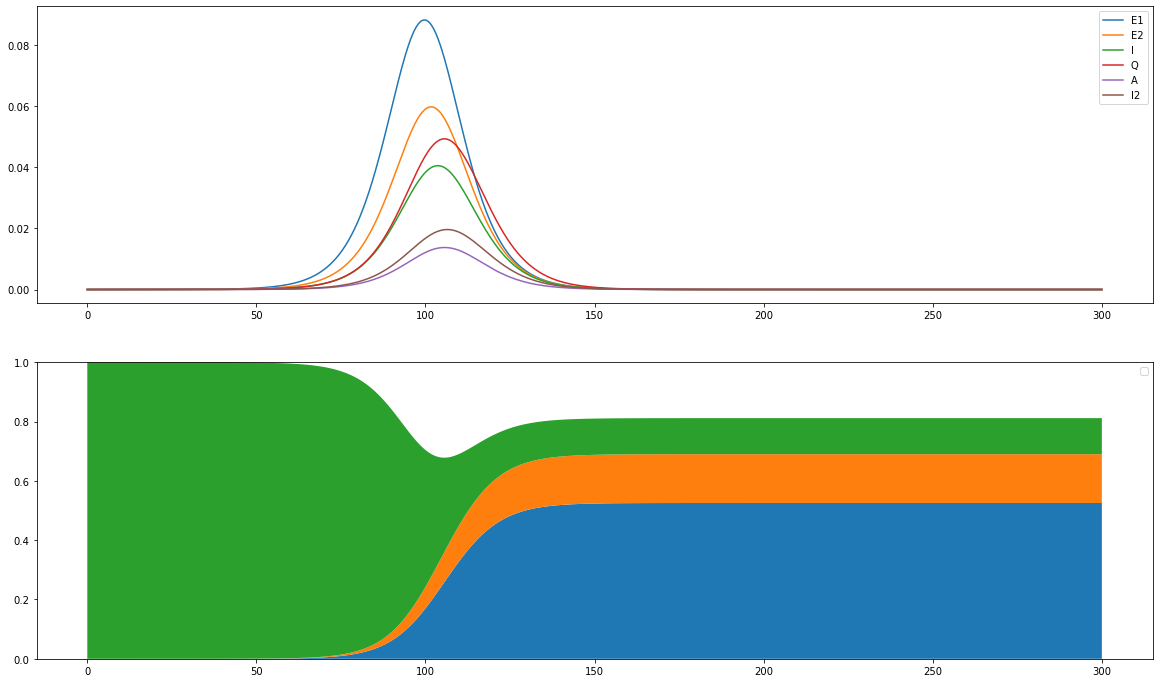

In [ ]:

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,12)) 

ax1.plot(sch1.result.t,sch1.result.E1,label='E1')
ax1.plot(sch1.result.t,sch1.result.E2,label='E2')
ax1.plot(sch1.result.t,sch1.result.I,label='I')
ax1.plot(sch1.result.t,sch1.result.Q,label='Q')
ax1.plot(sch1.result.t,sch1.result.A,label='A')
ax1.plot(sch1.result.t,sch1.result.I2,label='I2')

ax2.stackplot(sch1.result.t,
        sch1.result.Rp,
        Rs,
        sch1.result.S
        # labels=['Recove']
    )

ax1.legend()
ax2.legend()

ax2.set_ylim([0,1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 1.0)

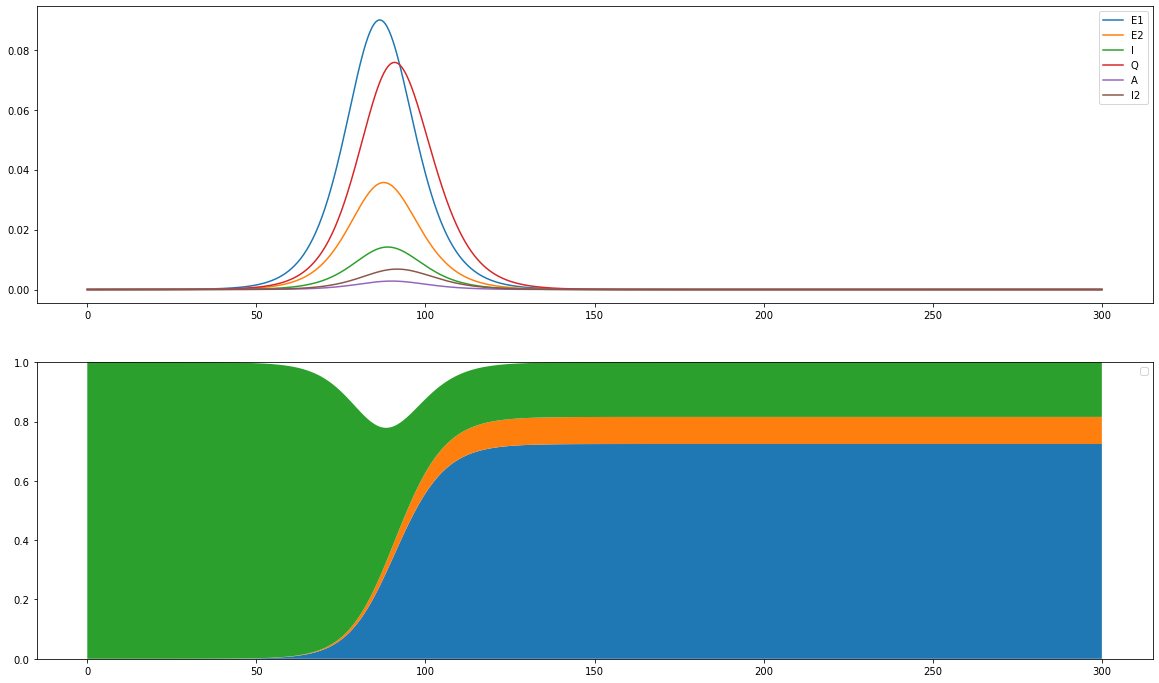

In [ ]:

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,12)) 

ax1.plot(sch1.result.t,sch1.result.E1,label='E1')
ax1.plot(sch1.result.t,sch1.result.E2,label='E2')
ax1.plot(sch1.result.t,sch1.result.I,label='I')
ax1.plot(sch1.result.t,sch1.result.Q,label='Q')
ax1.plot(sch1.result.t,sch1.result.A,label='A')
ax1.plot(sch1.result.t,sch1.result.I2,label='I2')

ax2.stackplot(sch1.result.t,
        sch1.result.Rp,
        Rs,
        sch1.result.S
        # labels=['Recove']
    )

ax1.legend()
ax2.legend()

ax2.set_ylim([0,1])

In [ ]:

# plt.figure() 
# ax = plt.axes(projection='3d')
# # ax.plot_surface(XX,YY,ZZ[1],vmax=1,vmin=0.5)
# # ax.plot_surface(XX,YY,ZZ[0])
# ax.contour3D(XX,YY,ZZ[1],vmax=1,vmin=0.5)
# ax.contour3D(XX,YY,ZZ[0])

# ax.set_zlim([0.5,0.9])
# # plt.colorbar()

In [ ]:
# testProbRange = np.linspace(1/2,1/10,2)
# betaRange = np.linspace(1,4,2)
# XX,YY = np.meshgrid(testProbRange,betaRange)
# ZZ = simAndGetRatios(XX,YY)[0]


In [ ]:
ZZ

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 1.0)

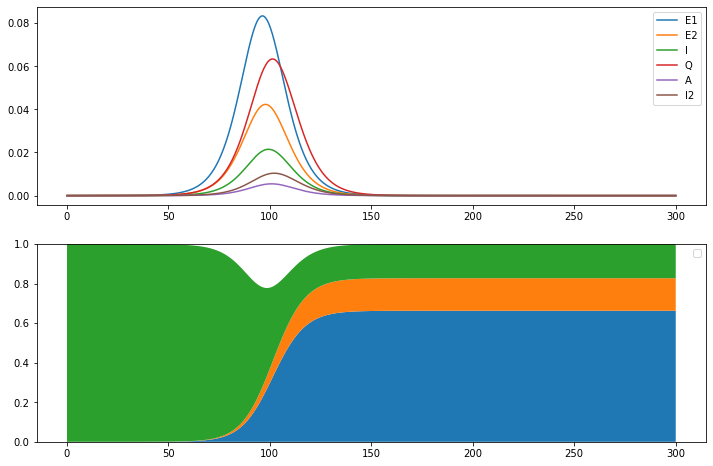

In [ ]:
asdf
# totInf = sch1.result.E1 + sch1.result.E2 + sch1.result.I + sch1.result.Q + sch1.result.A + sch1.result.I2
# testPos = testProb * (sch1.result.E2 + sch1.result.I + sch1.result.A)

fig,(ax1,ax2) = plt.subplots(2,1) 

# ax1.plot(sch1.result.t,totInf)
# # ax1.plot(sch1.result.t,testPos)
# ax1.plot(sch1.result.t,sch1.result.Q)
# ax1.plot(sch1.result.t,sch1.result.Q+sch1.result.I2)

ax1.plot(sch1.result.t,sch1.result.E1,label='E1')
ax1.plot(sch1.result.t,sch1.result.E2,label='E2')
ax1.plot(sch1.result.t,sch1.result.I,label='I')
ax1.plot(sch1.result.t,sch1.result.Q,label='Q')
ax1.plot(sch1.result.t,sch1.result.A,label='A')
ax1.plot(sch1.result.t,sch1.result.I2,label='I2')

# ax2.plot(sch1.result.t,sch1.result.Rp,label='Recovered, positive')
# ax2.plot(sch1.result.t,Rs,label='Recovered, never positive')
ax2.stackplot(sch1.result.t,
        sch1.result.Rp,
        Rs,
        sch1.result.S
        # labels=['Recove']
    )

ax1.legend()
ax2.legend()

ax2.set_ylim([0,1])

# ax1.plot(sch1.result.t,Rs)
# ax1.plot(sch1.result.t,sch1.result.S)
# ax1.plot(sch1.result.t,1-Rs-sch1.result.S)

# ax1.legend()

# fig,ax2 = plt.subplots()
# ax2.stackplot(sch1.result.t,
#         # sch1.result.E1 + sch1.result.E2 + sch1.result.I + sch1.result.A,
#         sch1.result.Q,
#         sch1.result.I2,
#         sch1.result.A
#     )

# Older tests

In [ ]:
# Initialize everything

DKpop = 5800000
iniExp = 10
iniInf = 0

I_0 = iniInf/DKpop 
E1_0 = iniExp/DKpop 
E2_0 = 0
A_0 = 0
Q_0 = 0
R_0 = 0
S_0 = 1 - I_0 - E1_0 - E2_0 - A_0 - Q_0 - R_0 

init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'I':I_0,'A':A_0,'Q':Q_0}

gamma = 1/2.5
nu = 1/3.5
beta = 3.5*nu 
beta = 5*nu 
sympRate = 0.25
testProb = 0.95 * 1/3
pars = {'beta':beta,'nu':nu,'gamma':gamma,'sympRate':sympRate,'testProb':testProb}


tEnd = 1000 
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])
sch1.simulate(tRes=10000)


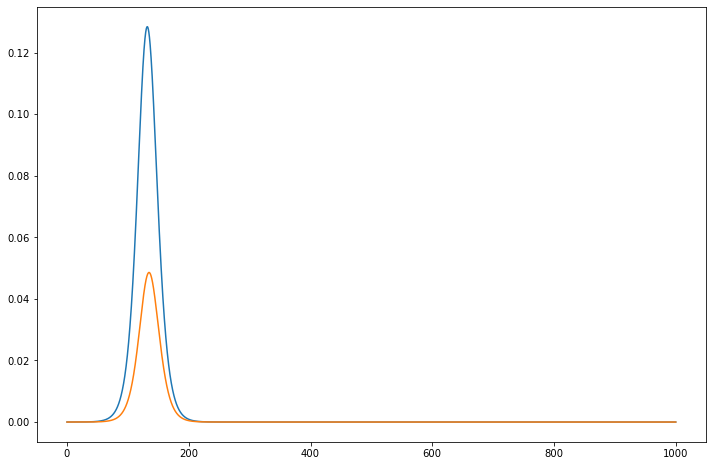

In [ ]:
Rs = 1- sch1.result.y.sum(axis=0)
totInf = sch1.result.E1 + sch1.result.E2 + sch1.result.I + sch1.result.Q + sch1.result.A 
testPos = testProb * (sch1.result.E2 + sch1.result.I + sch1.result.A)

fig,ax1 = plt.subplots() 

ax1.plot(sch1.result.t,totInf)
# ax1.plot(sch1.result.t,testPos)
ax1.plot(sch1.result.t,sch1.result.Q)

# ax1.plot(sch1.result.t,sch1.result.E1)
# ax1.plot(sch1.result.t,sch1.result.E2)
# ax1.plot(sch1.result.t,sch1.result.I)
# ax1.plot(sch1.result.t,sch1.result.Q)
# ax1.plot(sch1.result.t,sch1.result.A)
# ax1.plot(sch1.result.t,Rs)
# ax1.plot(sch1.result.t,sch1.result.S)


# ax1.stackplot(sch1.result.t,
#         sch1.result.S,
#         sch1.result.E1,
#         sch1.result.E2,
#         sch1.result.I,
#         sch1.result.Q,
#         sch1.result.A,
#         Rs,
#     )

In [ ]:
# Initialize everything

DKpop = 5800000
iniExp = 10
iniInf = 0

I_0 = iniInf/DKpop 
E1_0 = iniExp/DKpop 
E2_0 = 0
A_0 = 0
Q_0 = 0
R_0 = 0
S_0 = 1 - I_0 - E1_0 - E2_0 - A_0 - Q_0 - R_0 

init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'I':I_0,'A':A_0,'Q':Q_0}

gamma = 1/2.5
nu = 1/3.5
beta = 3.5*nu 
sympRate = 0.5
pars = {'beta':beta,'nu':nu,'gamma':gamma,'sympRate':sympRate}


tEnd = 120 
sch1 = pmf.Scheme(modelMeta_noTest,init,pars,0,tEnd,Changes=[])
sch1.simulate(tRes=10000)


array([1.        , 1.        , 1.        , ..., 0.01537591, 0.01537553,
       0.01537515])

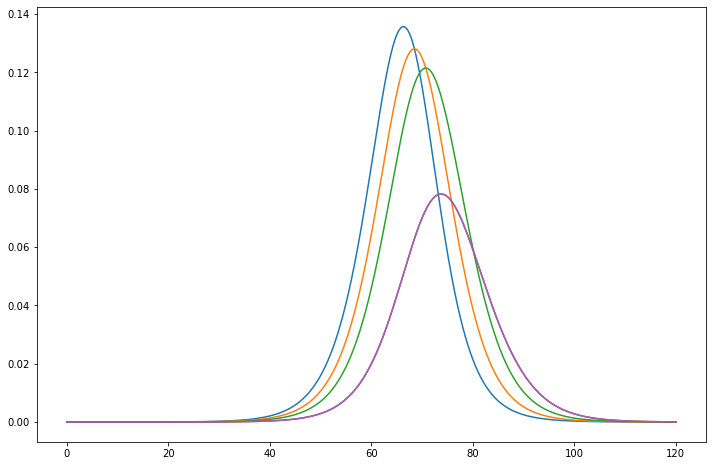

In [ ]:
Rs = 1- sch1.result.y.sum(axis=0)

fig,ax1 = plt.subplots() 
ax1.plot(sch1.result.t,sch1.result.E1)
ax1.plot(sch1.result.t,sch1.result.E2)
ax1.plot(sch1.result.t,sch1.result.I)
ax1.plot(sch1.result.t,sch1.result.Q)
ax1.plot(sch1.result.t,sch1.result.A)
# ax1.plot(sch1.result.t,Rs)
# ax1.plot(sch1.result.t,sch1.result.S)


# ax1.stackplot(sch1.result.t,
#         sch1.result.S,
#         sch1.result.E1,
#         sch1.result.E2,
#         sch1.result.I,
#         sch1.result.Q,
#         sch1.result.A,
#         Rs,
#     )